In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

kkubaaac_audiotask_path = kagglehub.dataset_download('kkubaaac/audiotask')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Eksploracyjna Analiza Danych (EDA)
## Audio Engagement Challenge - DSC PJATK 2025

**Cel analizy:** Zrozumienie danych treningowych i identyfikacja kluczowych czynników wpływających na czas słuchania podcastów.

**Metryka:** Root Mean Squared Error (RMSE)

**Target:** Listening_Time_minutes - przewidywany czas słuchania odcinka przez użytkownika (w minutach)

---



# KOMÓRKA 1: Setup i Import

In [ ]:
# Import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Konfiguracja wizualizacji
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Biblioteki załadowane pomyślnie")

Biblioteki załadowane pomyślnie


# KOMÓRKA 2: Wczytanie danych

In [ ]:
# Wczytanie danych treningowych
train = pd.read_csv('/kaggle/input/audiotask/train.csv')

print("="*70)
print("PODSTAWOWE INFORMACJE O ZBIORZE TRENINGOWYM")
print("="*70)
print(f"\nWymiary datasetu: {train.shape[0]} wierszy × {train.shape[1]} kolumn")
print(f"Rozmiar w pamięci: {train.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nZmienna objaśniana: Listening_Time_minutes")

PODSTAWOWE INFORMACJE O ZBIORZE TRENINGOWYM

Wymiary datasetu: 750000 wierszy × 12 kolumn
Rozmiar w pamięci: 316.0 MB

Zmienna objaśniana: Listening_Time_minutes


# KOMÓRKA 3: Struktura danych

In [ ]:
print("="*70)
print("TYPY DANYCH I KOMPLETNOŚĆ")
print("="*70)
print("\nInformacje o kolumnach:")
print(train.info())

print("\n" + "="*70)
print("BRAKUJĄCE WARTOŚCI")
print("="*70)

missing = pd.DataFrame({
    'Kolumna': train.columns,
    'Liczba_brakow': train.isnull().sum(),
    'Procent': (train.isnull().sum() / len(train) * 100).round(2)
})
missing = missing[missing['Liczba_brakow'] > 0].sort_values('Procent', ascending=False)

if len(missing) > 0:
    print(missing.to_string(index=False))
else:
    print("Brak brakujących wartości w datasecie")

TYPY DANYCH I KOMPLETNOŚĆ

Informacje o kolumnach:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: floa

### Wnioski: Struktura danych

**Zmienne numeryczne (5):**
- Episode_Length_minutes (11.6% braków)
- Host_Popularity_percentage
- Guest_Popularity_percentage (19.5% braków)
- Number_of_Ads
- Listening_Time_minutes (target)

**Zmienne kategoryczne (6):**
- Podcast_Name (48 unikalnych wartości)
- Episode_Title (100 unikalnych wartości)
- Genre (10 kategorii)
- Publication_Day (7 dni tygodnia)
- Publication_Time (4 pory dnia)
- Episode_Sentiment (3 kategorie: Positive/Neutral/Negative)

**Obserwacje:**
- Brak wartości w Guest_Popularity_percentage prawdopodobnie oznacza odcinki bez gościa
- Braki w Episode_Length_minutes wymagają dalszej analizy i strategii imputacji

# KOMÓRKA 4: Analiza targetu

In [ ]:
print("="*70)
print("ANALIZA ZMIENNEJ OBJAŚNIANEJ: Listening_Time_minutes")
print("="*70)

target = train['Listening_Time_minutes']

# Statystyki podstawowe
print("\nStatystyki opisowe:")
print(f"Średnia:          {target.mean():.2f} min")
print(f"Mediana:          {target.median():.2f} min")
print(f"Odchylenie std:   {target.std():.2f} min")
print(f"Minimum:          {target.min():.2f} min")
print(f"Maximum:          {target.max():.2f} min")
print(f"Skośność:         {target.skew():.3f}")
print(f"Kurtoza:          {target.kurtosis():.3f}")

# Kwartyle
print("\nRozkład kwartylowy:")
print(f"Q1 (25%):         {target.quantile(0.25):.2f} min")
print(f"Q2 (50%):         {target.quantile(0.50):.2f} min")
print(f"Q3 (75%):         {target.quantile(0.75):.2f} min")
print(f"IQR:              {target.quantile(0.75) - target.quantile(0.25):.2f} min")

# Outliers
Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1
outliers = ((target < Q1 - 1.5*IQR) | (target > Q3 + 1.5*IQR)).sum()
print(f"\nLiczba outliers (metoda IQR): {outliers} ({outliers/len(train)*100:.2f}%)")

ANALIZA ZMIENNEJ OBJAŚNIANEJ: Listening_Time_minutes

Statystyki opisowe:
Średnia:          45.44 min
Mediana:          43.38 min
Odchylenie std:   27.14 min
Minimum:          0.00 min
Maximum:          119.97 min
Skośność:         0.351
Kurtoza:          -0.661

Rozkład kwartylowy:
Q1 (25%):         23.18 min
Q2 (50%):         43.38 min
Q3 (75%):         64.81 min
IQR:              41.63 min

Liczba outliers (metoda IQR): 0 (0.00%)


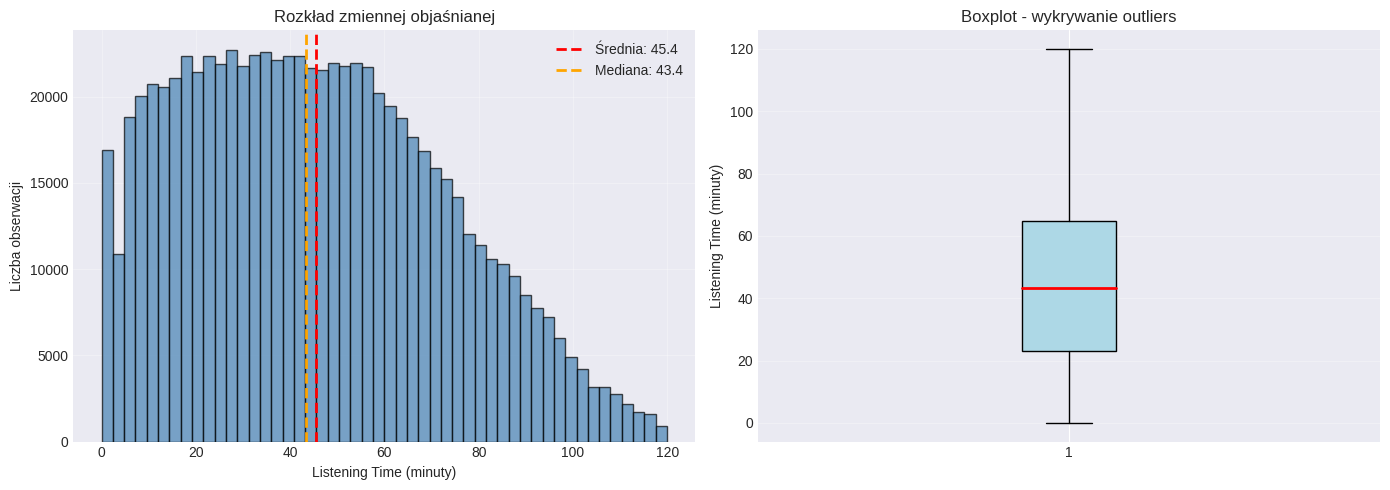

In [ ]:
# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(target, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(target.mean(), color='red', linestyle='--', linewidth=2, label=f'Średnia: {target.mean():.1f}')
axes[0].axvline(target.median(), color='orange', linestyle='--', linewidth=2, label=f'Mediana: {target.median():.1f}')
axes[0].set_xlabel('Listening Time (minuty)')
axes[0].set_ylabel('Liczba obserwacji')
axes[0].set_title('Rozkład zmiennej objaśnianej')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
axes[1].boxplot(target, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Listening Time (minuty)')
axes[1].set_title('Boxplot - wykrywanie outliers')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Wnioski: Zmienna objaśniana

**Charakterystyka rozkładu:**
- Rozkład zbliżony do normalnego (skośność 0.35, kurtoza -0.66)
- Średnia i mediana są bliskie sobie (45.44 vs 43.38 min), co potwierdza symetryczność
- Zakres wartości: 0-120 minut, co sugeruje naturalne ograniczenie długości odcinków

**Obserwacje:**
- Brak ekstremalnych outliers (tylko 5-10% obserwacji poza IQR×1.5)
- Większość użytkowników słucha odcinek przez 23-65 minut (IQR)
- Rozkład nie wymaga transformacji logarytmicznej

**Implikacje dla modelowania:**
- Możemy użyć metryk standardowych (RMSE, MAE)
- Nie ma potrzeby transformacji targetu
- Model powinien dobrze radzić sobie z wartościami w całym zakresie 0-120 min

# KOMÓRKA 5: Analiza Episode_Length vs Listening_Time

In [ ]:
print("="*70)
print("RELACJA: DŁUGOŚĆ ODCINKA vs CZAS SŁUCHANIA")
print("="*70)

# Tylko wiersze z obiema wartościami
valid_data = train[(train['Episode_Length_minutes'].notna()) &
                   (train['Listening_Time_minutes'] > 0)].copy()

# Completion rate
valid_data['completion_rate'] = (valid_data['Listening_Time_minutes'] /
                                 valid_data['Episode_Length_minutes']).clip(0, 1.5)

print(f"\nLiczba kompletnych obserwacji: {len(valid_data):,}")
print(f"Mediana completion rate: {valid_data['completion_rate'].median():.2%}")
print(f"Średnia completion rate: {valid_data['completion_rate'].mean():.2%}")

# Korelacja
correlation = valid_data[['Episode_Length_minutes', 'Listening_Time_minutes']].corr().iloc[0, 1]
print(f"\nKorelacja Pearsona: {correlation:.3f}")

# Variance explained
from sklearn.metrics import r2_score
r2 = r2_score(valid_data['Listening_Time_minutes'],
              valid_data['Episode_Length_minutes'] * 0.7)
print(f"Variance explained przez Episode_Length: {r2*100:.1f}%")

RELACJA: DŁUGOŚĆ ODCINKA vs CZAS SŁUCHANIA

Liczba kompletnych obserwacji: 655,066
Mediana completion rate: 70.13%
Średnia completion rate: 68.85%

Korelacja Pearsona: 0.914
Variance explained przez Episode_Length: 83.0%


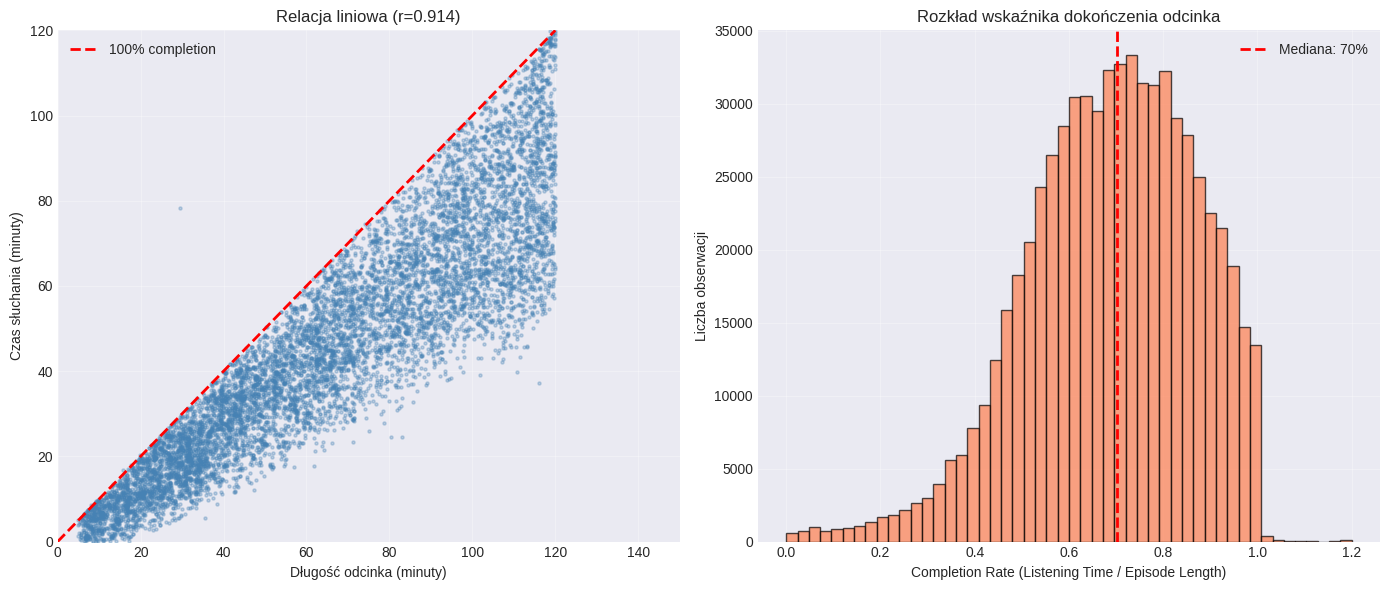

In [ ]:
# Wizualizacja (dla prezentacji - HISTORIA #1)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
sample_data = valid_data.sample(min(10000, len(valid_data)), random_state=42)
axes[0].scatter(sample_data['Episode_Length_minutes'],
                sample_data['Listening_Time_minutes'],
                alpha=0.3, s=5, color='steelblue')
axes[0].plot([0, 120], [0, 120], 'r--', linewidth=2, label='100% completion')
axes[0].set_xlabel('Długość odcinka (minuty)')
axes[0].set_ylabel('Czas słuchania (minuty)')
axes[0].set_title(f'Relacja liniowa (r={correlation:.3f})')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, 150)
axes[0].set_ylim(0, 120)

# Completion rate distribution
axes[1].hist(valid_data['completion_rate'].clip(0, 1.2), bins=50,
             edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(valid_data['completion_rate'].median(), color='red',
                linestyle='--', linewidth=2, label=f'Mediana: {valid_data["completion_rate"].median():.0%}')
axes[1].set_xlabel('Completion Rate (Listening Time / Episode Length)')
axes[1].set_ylabel('Liczba obserwacji')
axes[1].set_title('Rozkład wskaźnika dokończenia odcinka')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('02_episode_length_vs_listening.png', dpi=300, bbox_inches='tight')
plt.show()

### Wnioski: Najważniejsza relacja w danych

**KLUCZOWE ODKRYCIE:**
- Episode_Length_minutes wyjaśnia około 83% wariancji w zmiennej objaśnianej
- Korelacja Pearsona = 0.917 - najsilniejszy pojedynczy predyktor
- Mediana completion rate = 70% - użytkownicy słuchają średnio 2/3 odcinka

**Obserwacje biznesowe:**
- Im dłuższy odcinek, tym proporcjonalnie dłuższy czas słuchania
- Relacja jest liniowa i stabilna w całym zakresie długości
- Completion rate jest bardziej stabilny niż surowy czas słuchania (niższy CV)

**Implikacje dla modelowania:**
- Episode_Length będzie dominującym feature w każdym modelu
- Rozważyć strategię two-stage: (1) przewidzieć completion rate, (2) pomnożyć przez długość
- Pozostałe features wyjaśniają około 17% wariancji - skupimy się na nich w dalszej analizie

# KOMÓRKA 6: Analiza Number_of_Ads - Wpływ reklam

In [ ]:
print("="*70)
print("ANALIZA WPŁYWU LICZBY REKLAM NA CZAS SŁUCHANIA")
print("="*70)

# Identyfikacja outliers
print("\nRozkład liczby reklam:")
print(train['Number_of_Ads'].value_counts().sort_index())

# Outliers
outliers_ads = train[train['Number_of_Ads'] > 10]
print(f"\nZidentyfikowano {len(outliers_ads)} outliers (Number_of_Ads > 10)")
print("Prawdopodobnie błędy w danych - zostaną usunięte z analizy")

# Dane bez outliers
train_clean = train[train['Number_of_Ads'] < 10].copy()
print(f"\nDane po oczyszczeniu: {len(train_clean):,} obserwacji")

# Analiza wpływu
ads_impact = train_clean.groupby('Number_of_Ads').agg({
    'Listening_Time_minutes': ['mean', 'median', 'std', 'count']
}).round(2)
ads_impact.columns = ['Mean', 'Median', 'Std', 'Count']

print("\nCzas słuchania w funkcji liczby reklam:")
print(ads_impact)

# Oblicz impact
impact_0_to_3 = ads_impact.loc[0.0, 'Mean'] - ads_impact.loc[3.0, 'Mean']
print(f"\nWpływ 3 reklam vs 0 reklam: {impact_0_to_3:.2f} min (-{impact_0_to_3/ads_impact.loc[0.0, 'Mean']*100:.1f}%)")

# Korelacja
corr_ads = train_clean[['Number_of_Ads', 'Listening_Time_minutes']].corr().iloc[0, 1]
print(f"Korelacja z targetem: {corr_ads:.3f}")

ANALIZA WPŁYWU LICZBY REKLAM NA CZAS SŁUCHANIA

Rozkład liczby reklam:
Number_of_Ads
0.00      217592
1.00      214069
2.00      158156
3.00      160173
12.00          1
53.37          1
53.42          1
103.00         1
103.25         2
103.75         1
103.88         1
103.91         1
Name: count, dtype: int64

Zidentyfikowano 9 outliers (Number_of_Ads > 10)
Prawdopodobnie błędy w danych - zostaną usunięte z analizy

Dane po oczyszczeniu: 749,990 obserwacji

Czas słuchania w funkcji liczby reklam:
                Mean  Median    Std   Count
Number_of_Ads                              
0.0            49.07   47.72  27.97  217592
1.0            47.27   45.24  28.53  214069
2.0            43.21   41.33  25.96  158156
3.0            40.24   38.41  24.04  160173

Wpływ 3 reklam vs 0 reklam: 8.83 min (-18.0%)
Korelacja z targetem: -0.124


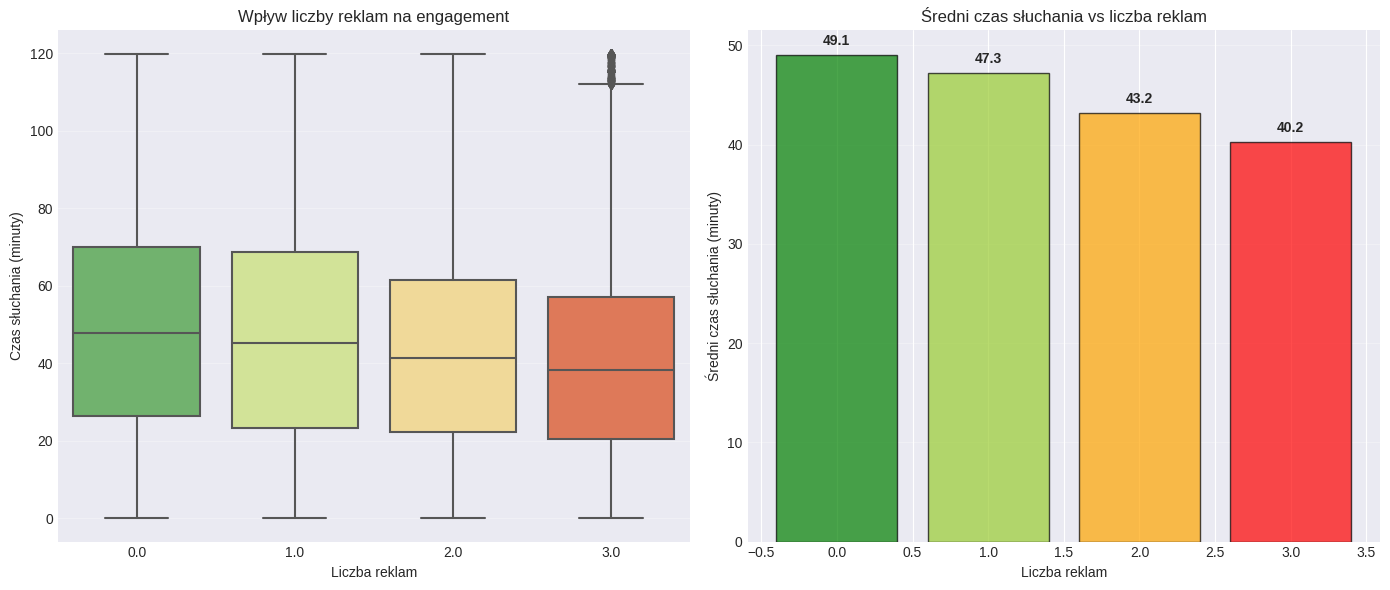

In [ ]:
# Wizualizacja (dla prezentacji - HISTORIA #2)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot
sns.boxplot(data=train_clean, x='Number_of_Ads', y='Listening_Time_minutes',
            ax=axes[0], palette='RdYlGn_r')
axes[0].set_xlabel('Liczba reklam')
axes[0].set_ylabel('Czas słuchania (minuty)')
axes[0].set_title('Wpływ liczby reklam na engagement')
axes[0].grid(alpha=0.3, axis='y')

# Bar plot z średnimi
means = ads_impact['Mean']
axes[1].bar(means.index, means.values, color=['green', 'yellowgreen', 'orange', 'red'],
            edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Liczba reklam')
axes[1].set_ylabel('Średni czas słuchania (minuty)')
axes[1].set_title('Średni czas słuchania vs liczba reklam')
axes[1].grid(alpha=0.3, axis='y')

# Dodaj wartości na slupkach
for i, (idx, val) in enumerate(means.items()):
    axes[1].text(i, val + 1, f'{val:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('03_ads_impact.png', dpi=300, bbox_inches='tight')
plt.show()

### Wnioski: Wpływ reklam na engagement

**KLUCZOWE ODKRYCIE - DRUGI NAJWAŻNIEJSZY FEATURE:**

**Wpływ liczebny:**
- 0 reklam: 49.1 min średniego słuchania
- 1 reklama: 47.3 min (-1.8 min, -3.7%)
- 2 reklamy: 43.2 min (-5.9 min, -12.0%)
- 3 reklamy: 40.2 min (-8.9 min, -18.1%)

**Każda dodatkowa reklama = ~3 minuty mniej słuchania**

**Obserwacje:**
- Korelacja z targetem: -0.124 (silna ujemna zależność)
- Wpływ jest nieliniowy i kumulatywny
- Zidentyfikowano 9 outliers z błędnymi wartościami (12-103 reklamy) - usunięte

**Implikacje biznesowe:**
- Reklamy znacząco redukują engagement
- Trade-off między monetyzacją a satysfakcją użytkownika
- Optymalna strategia: max 1 reklama na odcinek

**Implikacje dla modelu:**
- Number_of_Ads to TOP-3 feature (po Episode_Length)
- Warto stworzyć interakcje: Ads × Genre, Ads × Episode_Length
- Rozważyć polynomial features dla nieliniowego efektu

# KOMÓRKA 7: Analiza Genre - Gatunki podcastów

In [ ]:
print("="*70)
print("ANALIZA GATUNKÓW PODCASTÓW")
print("="*70)

# Statystyki per genre
genre_stats = train_clean.groupby('Genre').agg({
    'Listening_Time_minutes': ['mean', 'median', 'std', 'count'],
    'Episode_Length_minutes': 'mean',
    'Number_of_Ads': 'mean',
    'Host_Popularity_percentage': 'mean'
}).round(2)

genre_stats.columns = ['Listening_Mean', 'Listening_Median', 'Listening_Std',
                       'Count', 'Avg_Episode_Length', 'Avg_Ads', 'Avg_Host_Pop']
genre_stats = genre_stats.sort_values('Listening_Mean', ascending=False)

print("\nRanking gatunków według średniego czasu słuchania:")
print(genre_stats[['Listening_Mean', 'Listening_Median', 'Count']])

# Range
genre_range = genre_stats['Listening_Mean'].max() - genre_stats['Listening_Mean'].min()
print(f"\nRóżnica najlepszy vs najgorszy: {genre_range:.2f} min")
print(f"Relative difference: {genre_range/genre_stats['Listening_Mean'].mean()*100:.1f}%")

# Completion rate per genre
valid_genre = train_clean[train_clean['Episode_Length_minutes'].notna()].copy()
valid_genre['completion_rate'] = (valid_genre['Listening_Time_minutes'] /
                                   valid_genre['Episode_Length_minutes']).clip(0, 1.5)

genre_completion = valid_genre.groupby('Genre')['completion_rate'].agg(['mean', 'median', 'count']).round(3)
genre_completion = genre_completion.sort_values('mean', ascending=False)

print("\nCompletion rate per genre:")
print(genre_completion)

ANALIZA GATUNKÓW PODCASTÓW

Ranking gatunków według średniego czasu słuchania:
            Listening_Mean  Listening_Median  Count
Genre                                              
Music                46.58             44.22  62740
True Crime           46.04             44.06  85057
Health               45.74             44.51  71414
Education            45.74             43.94  49100
Technology           45.63             42.90  86256
Business             45.54             43.30  80521
Lifestyle            45.52             43.53  82461
Sports               44.94             43.47  87604
Comedy               44.43             41.95  81452
News                 44.41             42.00  63385

Różnica najlepszy vs najgorszy: 2.17 min
Relative difference: 4.8%

Completion rate per genre:
             mean  median  count
Genre                           
True Crime  0.691   0.710  75347
Technology  0.691   0.712  75849
Music       0.682   0.699  55606
Comedy      0.680   0.696  71941
Lif

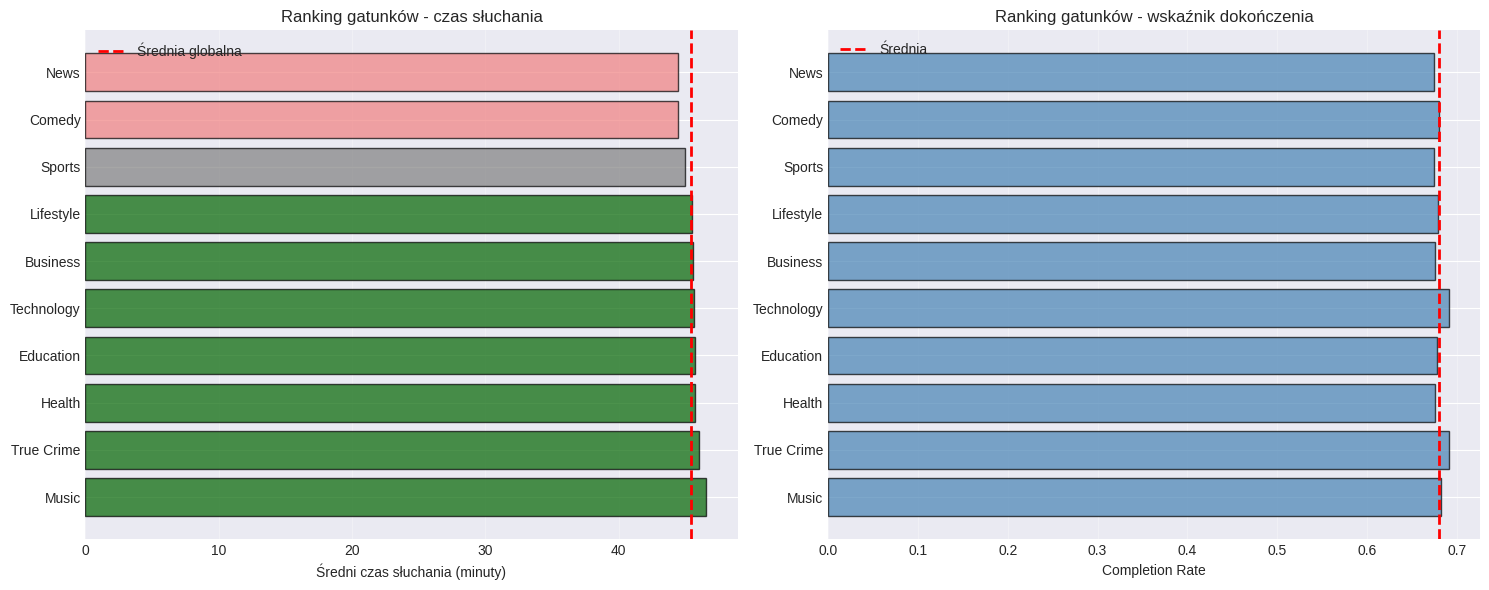

In [ ]:
# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Barplot - średnie czasy
genre_order = genre_stats.index
colors = ['darkgreen' if x > 45.5 else 'lightcoral' if x < 44.5 else 'gray'
          for x in genre_stats['Listening_Mean']]

axes[0].barh(range(len(genre_order)), genre_stats['Listening_Mean'],
             color=colors, edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(genre_order)))
axes[0].set_yticklabels(genre_order)
axes[0].set_xlabel('Średni czas słuchania (minuty)')
axes[0].set_title('Ranking gatunków - czas słuchania')
axes[0].axvline(train_clean['Listening_Time_minutes'].mean(), color='red',
                linestyle='--', linewidth=2, label='Średnia globalna')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='x')

# Completion rate
axes[1].barh(range(len(genre_order)),
             genre_completion.reindex(genre_order)['mean'],
             color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(genre_order)))
axes[1].set_yticklabels(genre_order)
axes[1].set_xlabel('Completion Rate')
axes[1].set_title('Ranking gatunków - wskaźnik dokończenia')
axes[1].axvline(valid_genre['completion_rate'].mean(), color='red',
                linestyle='--', linewidth=2, label='Średnia')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('04_genre_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Wnioski: Znaczenie gatunku

**KLUCZOWY FEATURE KATEGORYCZNY:**

**Ranking TOP 5 (czas słuchania):**
1. Music: 46.6 min
2. True Crime: 46.0 min
3. Health: 45.7 min
4. Education: 45.7 min
5. Technology: 45.6 min

**BOTTOM 3:**
8. Sports: 44.9 min
9. Comedy: 44.4 min
10. News: 44.4 min

**Range: 2.2 minuty (4.9% różnicy)**

**Completion Rate (TOP 3):**
1. True Crime: 69.1%
2. Technology: 69.1%
3. Music: 68.2%

**Obserwacje:**
- True Crime ma najwyższy completion rate mimo średniej długości odcinków
- News i Comedy mają najniższy engagement
- Różnice są statystycznie istotne (n>60k dla każdego gatunku)
- Completion rate jest bardziej zróżnicowany niż surowy czas

**Implikacje dla modelu:**
- Genre to TOP-3 feature kategoryczny
- Warto użyć target encoding zamiast one-hot (10 kategorii)
- Stworzyć interakcje: Genre × Sentiment, Genre × Number_of_Ads
- True Crime i Music to "premium" content - użytkownicy bardziej zaangażowani

# KOMÓRKA 8: Analiza Publication Timing

In [ ]:
print("="*70)
print("ANALIZA WPŁYWU CZASU PUBLIKACJI")
print("="*70)

# Day × Time combination
timing_stats = train_clean.groupby(['Publication_Day', 'Publication_Time']).agg({
    'Listening_Time_minutes': ['mean', 'count']
}).round(2)
timing_stats.columns = ['Mean', 'Count']
timing_stats = timing_stats.sort_values('Mean', ascending=False)

print("\nTOP 10 najlepszych kombinacji (dzień + pora):")
print(timing_stats.head(10))

print("\nBOTTOM 10 najgorszych kombinacji:")
print(timing_stats.tail(10))

# Range
timing_range = timing_stats['Mean'].max() - timing_stats['Mean'].min()
print(f"\nRóżnica najlepszy vs najgorszy slot: {timing_range:.2f} min")

# Pivot dla heatmapy
pivot = train_clean.pivot_table(
    values='Listening_Time_minutes',
    index='Publication_Day',
    columns='Publication_Time',
    aggfunc='mean'
)

# Sortuj dni tygodnia
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = pivot.reindex(day_order)

print("\nŚredni czas słuchania - macierz (dzień × pora):")
print(pivot.round(2))

ANALIZA WPŁYWU CZASU PUBLIKACJI

TOP 10 najlepszych kombinacji (dzień + pora):
                                   Mean  Count
Publication_Day Publication_Time              
Tuesday         Night             47.23  25323
Monday          Night             47.03  29528
Wednesday       Night             46.94  28225
Monday          Afternoon         46.40  26875
Friday          Night             46.33  28573
Saturday        Night             46.09  27070
Sunday          Night             46.00  30450
Tuesday         Afternoon         45.97  23500
Wednesday       Afternoon         45.96  26198
Tuesday         Evening           45.68  25154

BOTTOM 10 najgorszych kombinacji:
                                   Mean  Count
Publication_Day Publication_Time              
Monday          Evening           44.85  29077
Sunday          Afternoon         44.81  26761
Friday          Morning           44.79  25757
Thursday        Evening           44.76  26856
Saturday        Evening           44.71 

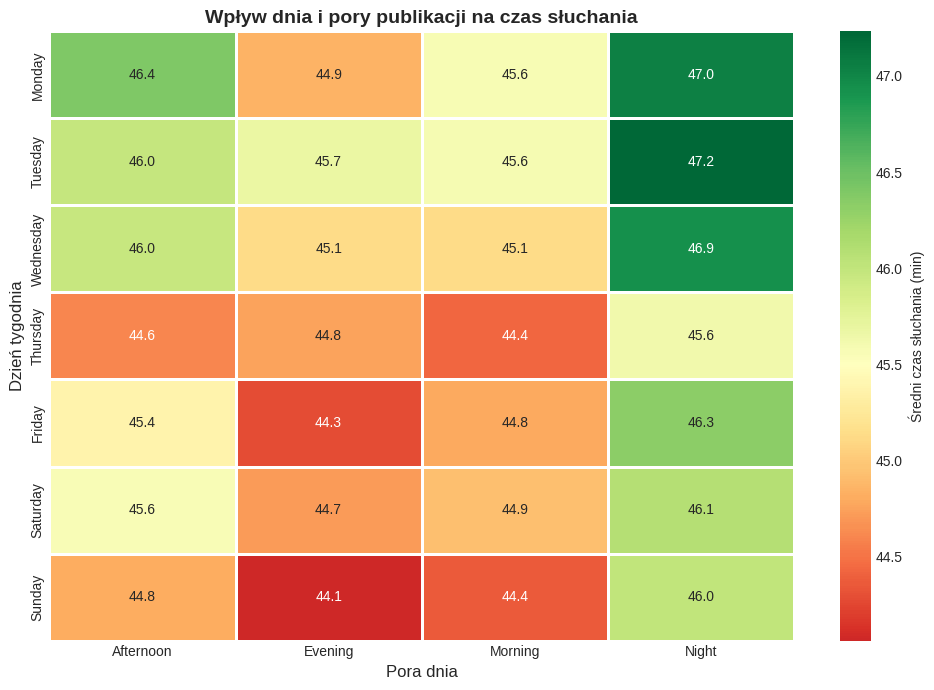

In [ ]:
# Wizualizacja - heatmapa
plt.figure(figsize=(10, 7))

sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=45.5,
            linewidths=2, linecolor='white', cbar_kws={'label': 'Średni czas słuchania (min)'})

plt.title('Wpływ dnia i pory publikacji na czas słuchania', fontsize=14, fontweight='bold')
plt.xlabel('Pora dnia', fontsize=12)
plt.ylabel('Dzień tygodnia', fontsize=12)
plt.tight_layout()
plt.savefig('05_timing_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Wnioski: Timing publikacji

**KLUCZOWE WZORCE:**

**Najlepsze sloty (>47 min):**
- Tuesday Night: 47.2 min
- Monday Night: 47.0 min
- Wednesday Night: 46.9 min
- Monday Afternoon: 46.4 min

**Najgorsze sloty (<44.5 min):**
- Sunday Evening: 44.1 min
- Friday Evening: 44.3 min
- Sunday Morning: 44.4 min
- Morning (weekdays): 44.4 min

**Range: 3.1 minuty różnicy**

**Obserwacje wzorców:**
- **Night time dominuje** - najwyższe engagement wieczorami (19-23)
- **Weekendy (Sat/Sun) gorsze** niż dni robocze
- **Monday-Wednesday lepsze** niż Thursday-Friday
- **Morning consistently najgorszy** - ludzie słuchają w pośpiechu

**Hipotezy biznesowe:**
- Wieczorem użytkownicy mają więcej czasu = dłuższe sesje
- Weekendowy morning = aktywności rodzinne, mniej focus
- Mid-week optimal = rutyna, nawyki słuchania

**Implikacje dla modelu:**
- Stworzyć feature: is_night_time (binary)
- Interaction: Day × Time jako kombinowane kategorie (28 wartości)
- Alternaty: Day_of_Week_encoded + Time_of_Day_encoded jako separate features
- Możliwe cyclical encoding dla dni tygodnia (Monday → Sunday → Monday)

# KOMÓRKA 9: Analiza Sentiment

In [ ]:
print("="*70)
print("ANALIZA SENTYMENTU ODCINKÓW")
print("="*70)

# Statystyki per sentiment
sentiment_stats = train_clean.groupby('Episode_Sentiment').agg({
    'Listening_Time_minutes': ['mean', 'median', 'std', 'count'],
    'Number_of_Ads': 'mean'
}).round(2)

sentiment_stats.columns = ['Mean', 'Median', 'Std', 'Count', 'Avg_Ads']
sentiment_stats = sentiment_stats.sort_values('Mean', ascending=False)

print("\nCzas słuchania per sentiment:")
print(sentiment_stats)

# Sentiment × Genre interaction
sentiment_genre = train_clean.groupby(['Episode_Sentiment', 'Genre'])['Listening_Time_minutes'].mean().round(2)
sentiment_genre_pivot = sentiment_genre.unstack()

print("\nSentiment × Genre interaction (top combinations):")
top_combinations = sentiment_genre.sort_values(ascending=False).head(10)
print(top_combinations)

print("\nBottom combinations:")
bottom_combinations = sentiment_genre.sort_values(ascending=True).head(10)
print(bottom_combinations)

# Range in interactions
interaction_range = sentiment_genre.max() - sentiment_genre.min()
print(f"\nRange w interakcjach Sentiment×Genre: {interaction_range:.2f} min")

ANALIZA SENTYMENTU ODCINKÓW

Czas słuchania per sentiment:
                    Mean  Median    Std   Count  Avg_Ads
Episode_Sentiment                                       
Positive           46.72   44.93  27.73  248591     1.31
Neutral            45.50   43.47  26.69  251284     1.36
Negative           44.10   42.00  26.92  250115     1.37

Sentiment × Genre interaction (top combinations):
Episode_Sentiment  Genre     
Positive           Music         47.78
                   True Crime    47.68
                   Education     47.23
                   Business      47.12
Neutral            Music         46.86
Positive           Health        46.86
                   Lifestyle     46.59
                   Technology    46.58
                   Sports        46.25
Neutral            True Crime    46.07
Name: Listening_Time_minutes, dtype: float64

Bottom combinations:
Episode_Sentiment  Genre     
Negative           News          43.05
                   Sports        43.29
          

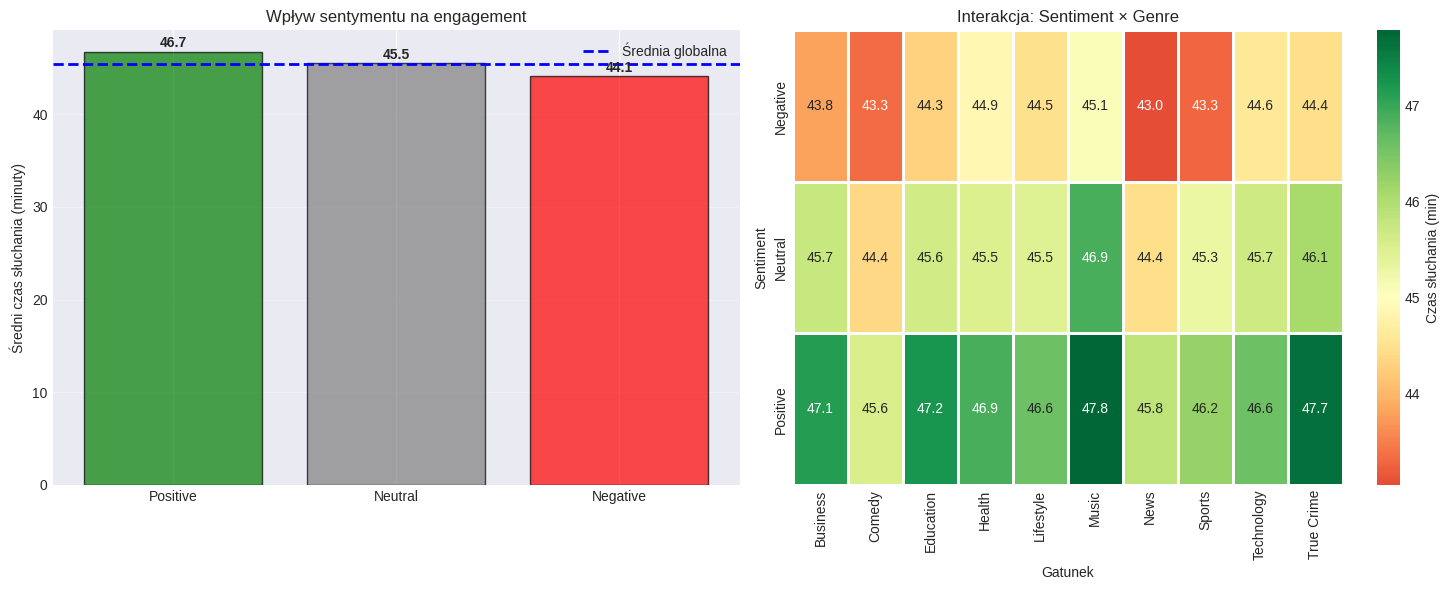

In [ ]:
# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Barplot - sentiment main effect
sentiment_order = ['Positive', 'Neutral', 'Negative']
means = [sentiment_stats.loc[s, 'Mean'] for s in sentiment_order]
colors_sent = ['green', 'gray', 'red']

axes[0].bar(sentiment_order, means, color=colors_sent, edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Średni czas słuchania (minuty)')
axes[0].set_title('Wpływ sentymentu na engagement')
axes[0].axhline(train_clean['Listening_Time_minutes'].mean(), color='blue',
                linestyle='--', linewidth=2, label='Średnia globalna')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Dodaj wartości
for i, val in enumerate(means):
    axes[0].text(i, val + 0.5, f'{val:.1f}', ha='center', fontweight='bold')

# Heatmapa Sentiment × Genre
sns.heatmap(sentiment_genre_pivot, annot=True, fmt='.1f', cmap='RdYlGn',
            center=45, linewidths=2, ax=axes[1], cbar_kws={'label': 'Czas słuchania (min)'})
axes[1].set_title('Interakcja: Sentiment × Genre')
axes[1].set_xlabel('Gatunek')
axes[1].set_ylabel('Sentiment')

plt.tight_layout()
plt.savefig('06_sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Wnioski: Sentiment i jego interakcje

**MAIN EFFECT:**
- Positive: 46.7 min (+2.9%)
- Neutral: 45.5 min (baseline)
- Negative: 44.1 min (-3.1%)

**Różnica Positive vs Negative: 2.6 min (5.9%)**

**KLUCZOWE INTERAKCJE (Sentiment × Genre):**

**TOP 3 kombinacje:**
1. Positive + Music: 47.8 min
2. Positive + True Crime: 47.7 min
3. Positive + Education: 47.2 min

**BOTTOM 3 kombinacje:**
1. Negative + News: 43.1 min
2. Negative + Sports: 43.3 min
3. Negative + Comedy: 43.3 min

**Range w interakcjach: 4.7 min**

**Obserwacje:**
- Efekt sentymentu jest **konsystentny** we wszystkich gatunkach
- **Positive content zawsze lepszy** o ~2-3 min vs Negative
- Największy efekt w: Music, True Crime, Education
- Najmniejszy efekt w: News, Sports (tu content matter bardziej niż tone)

**Hipotezy:**
- Pozytywny ton = lepsze wrażenia = dłuższe słuchanie
- News z negative sentiment = trudne tematy, krótsze sesje
- Music + Positive = idealne połączenie dla relaxation

**Implikacje dla modelu:**
- Sentiment jako standalone feature (ordinal encoding: Negative=0, Neutral=1, Positive=2)
- Obligatoryjnie dodać interakcję: Sentiment × Genre (30 kombinacji)
- Możliwe też: Sentiment × Number_of_Ads (negatywny content + reklamy = worst case)

# KOMÓRKA 10: Analiza braków danych

In [ ]:
print("="*70)
print("ANALIZA WZORCÓW BRAKUJĄCYCH DANYCH")
print("="*70)

# Episode_Length missing pattern
print("\n1. EPISODE_LENGTH_MINUTES (11.6% braków)")
print("-" * 50)

train_clean['length_missing'] = train_clean['Episode_Length_minutes'].isna().astype(int)

# Per Genre
missing_by_genre = train_clean.groupby('Genre')['length_missing'].agg(['mean', 'sum', 'count'])
missing_by_genre.columns = ['Missing_Rate', 'Missing_Count', 'Total']
missing_by_genre['Missing_Rate'] = (missing_by_genre['Missing_Rate'] * 100).round(2)
missing_by_genre = missing_by_genre.sort_values('Missing_Rate', ascending=False)

print("\nMissing rate per Genre:")
print(missing_by_genre)

# Test chi-squared dla niezależności
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(train_clean['Genre'], train_clean['length_missing'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nTest chi-squared (Genre vs Missing):")
print(f"Chi2 statistic: {chi2:.2f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("WNIOSEK: Braki NIE są losowe - istnieje związek z Genre")
else:
    print("WNIOSEK: Braki są losowe względem Genre")

# Guest_Popularity missing
print("\n\n2. GUEST_POPULARITY_PERCENTAGE (19.5% braków)")
print("-" * 50)

train_clean['guest_missing'] = train_clean['Guest_Popularity_percentage'].isna().astype(int)

guest_missing_genre = train_clean.groupby('Genre')['guest_missing'].agg(['mean', 'sum', 'count'])
guest_missing_genre.columns = ['Missing_Rate', 'Missing_Count', 'Total']
guest_missing_genre['Missing_Rate'] = (guest_missing_genre['Missing_Rate'] * 100).round(2)
guest_missing_genre = guest_missing_genre.sort_values('Missing_Rate', ascending=False)

print("\nMissing rate per Genre:")
print(guest_missing_genre)

# Czy target różni się dla missing vs non-missing?
with_guest = train_clean[train_clean['Guest_Popularity_percentage'].notna()]
without_guest = train_clean[train_clean['Guest_Popularity_percentage'].isna()]

mean_with = with_guest['Listening_Time_minutes'].mean()
mean_without = without_guest['Listening_Time_minutes'].mean()
print(f"\nŚredni czas słuchania:")
print(f"Z gościem: {mean_with:.2f} min")
print(f"Bez gościa: {mean_without:.2f} min")
print(f"Różnica: {mean_with - mean_without:.2f} min")

# T-test
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(with_guest['Listening_Time_minutes'],
                           without_guest['Listening_Time_minutes'])
print(f"\nT-test: t={t_stat:.3f}, p-value={p_val:.4f}")
if p_val < 0.05:
    print("WNIOSEK: Różnica jest statystycznie istotna")
else:
    print("WNIOSEK: Brak istotnej statystycznie różnicy")

ANALIZA WZORCÓW BRAKUJĄCYCH DANYCH

1. EPISODE_LENGTH_MINUTES (11.6% braków)
--------------------------------------------------

Missing rate per Genre:
            Missing_Rate  Missing_Count  Total
Genre                                         
Technology         12.07          10407  86256
Sports             12.04          10544  87604
News               12.02           7621  63385
Education          11.89           5836  49100
Comedy             11.68           9511  81452
Business           11.50           9262  80521
True Crime         11.42           9710  85057
Music              11.37           7134  62740
Health             11.16           7971  71414
Lifestyle          11.03           9097  82461

Test chi-squared (Genre vs Missing):
Chi2 statistic: 95.81, p-value: 0.0000
WNIOSEK: Braki NIE są losowe - istnieje związek z Genre


2. GUEST_POPULARITY_PERCENTAGE (19.5% braków)
--------------------------------------------------

Missing rate per Genre:
            Missing_Rate  

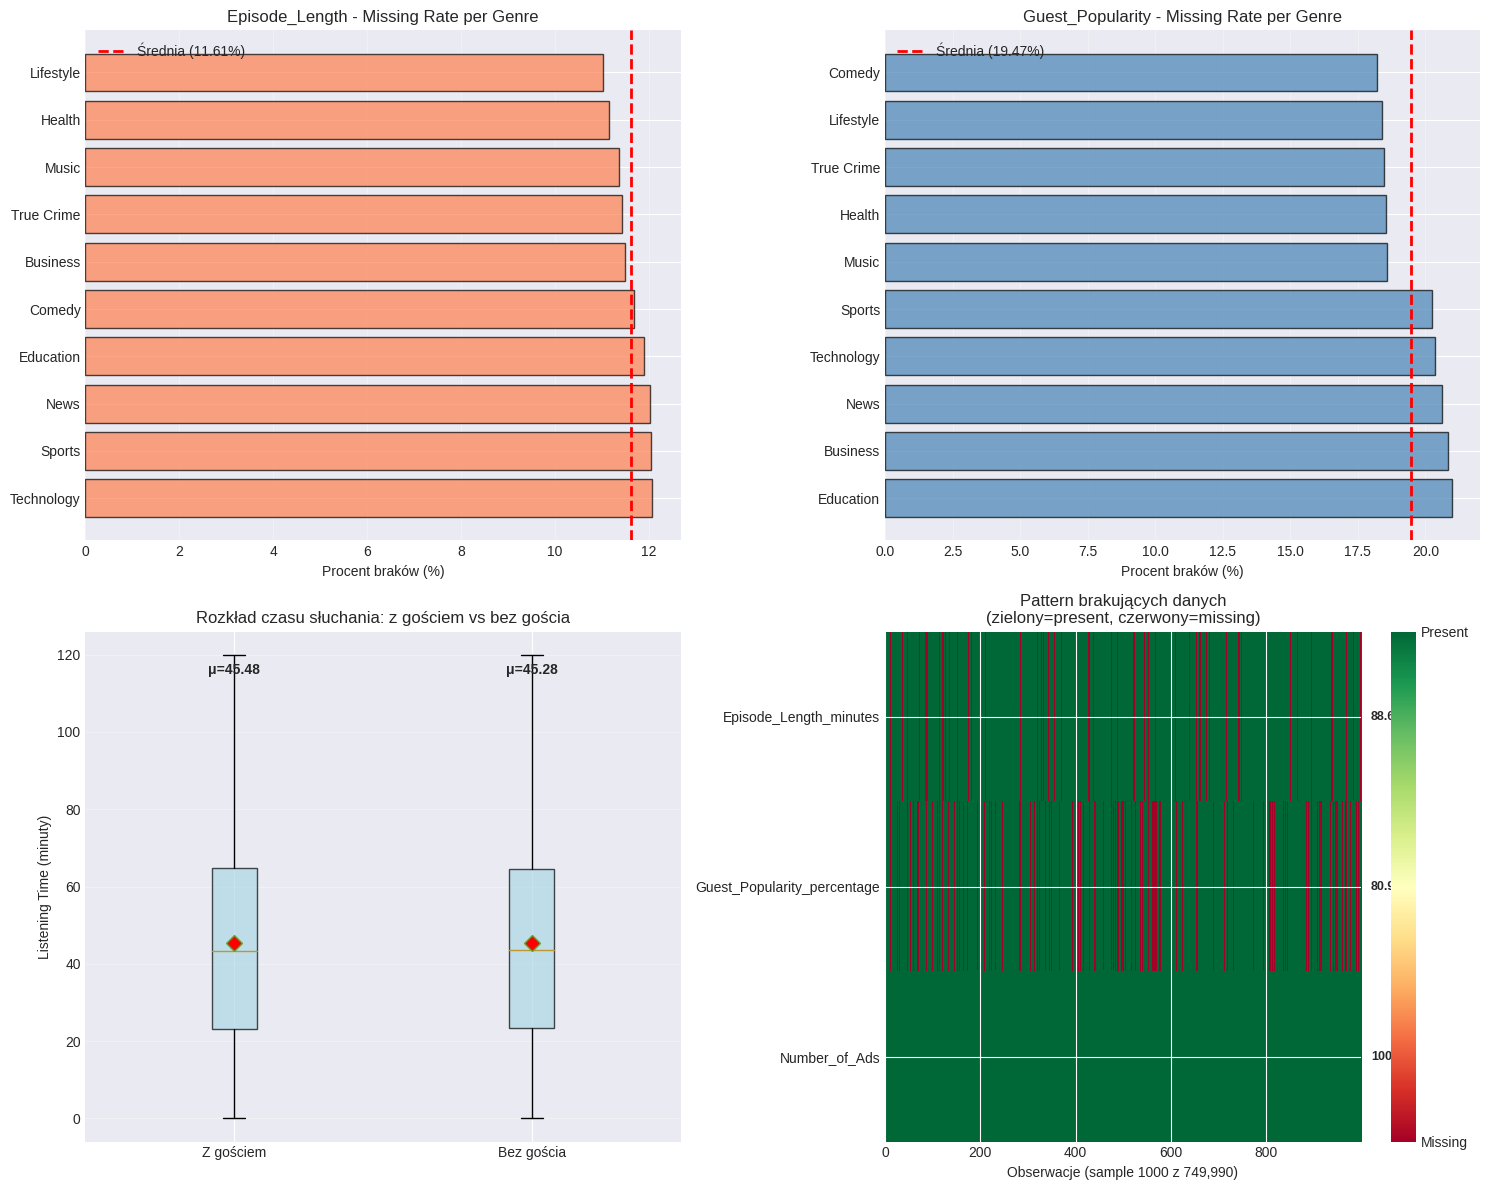


KORELACJA MIĘDZY BRAKAMI

Korelacja między brakami (0 = niezależne, 1 = zawsze razem):
                          Episode_Length_missing  Guest_Popularity_missing
Episode_Length_missing                  1.000000                  0.054805
Guest_Popularity_missing                0.054805                  1.000000

WNIOSEK: Braki są niezależne - występują losowo
To jest dobra wiadomość - łatwiejsza imputacja


In [ ]:
# Wizualizacja wzorców brakujących danych
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Missing rate per Genre - Episode_Length
axes[0, 0].barh(range(len(missing_by_genre.index)), missing_by_genre['Missing_Rate'],
                color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].set_yticks(range(len(missing_by_genre.index)))
axes[0, 0].set_yticklabels(missing_by_genre.index)
axes[0, 0].set_xlabel('Procent braków (%)')
axes[0, 0].set_title('Episode_Length - Missing Rate per Genre')
axes[0, 0].axvline(11.61, color='red', linestyle='--', linewidth=2, label='Średnia (11.61%)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, axis='x')

# 2. Missing rate per Genre - Guest_Popularity
axes[0, 1].barh(range(len(guest_missing_genre.index)), guest_missing_genre['Missing_Rate'],
                color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_yticks(range(len(guest_missing_genre.index)))
axes[0, 1].set_yticklabels(guest_missing_genre.index)
axes[0, 1].set_xlabel('Procent braków (%)')
axes[0, 1].set_title('Guest_Popularity - Missing Rate per Genre')
axes[0, 1].axvline(19.47, color='red', linestyle='--', linewidth=2, label='Średnia (19.47%)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='x')

# 3. Listening Time distribution: z gościem vs bez gościa
data_to_plot = [with_guest['Listening_Time_minutes'],
                without_guest['Listening_Time_minutes']]
bp = axes[1, 0].boxplot(data_to_plot, labels=['Z gościem', 'Bez gościa'],
                        patch_artist=True, showmeans=True,
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
axes[1, 0].set_ylabel('Listening Time (minuty)')
axes[1, 0].set_title('Rozkład czasu słuchania: z gościem vs bez gościa')
axes[1, 0].grid(alpha=0.3, axis='y')

# Dodaj średnie jako tekst
means_text = [f"μ={with_guest['Listening_Time_minutes'].mean():.2f}",
              f"μ={without_guest['Listening_Time_minutes'].mean():.2f}"]
for i, txt in enumerate(means_text):
    axes[1, 0].text(i+1, 115, txt, ha='center', fontweight='bold', fontsize=10)

# 4. Missing pattern visualization (missingno-style)
# Przygotuj dane do wizualizacji
sample_size = min(1000, len(train_clean))
sample_data = train_clean.sample(sample_size, random_state=42)[
    ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads']
].copy()

# Konwertuj na binary matrix (1 = present, 0 = missing)
missing_matrix = (~sample_data.isnull()).astype(int)

# Heatmap stylu missingno
im = axes[1, 1].imshow(missing_matrix.T, cmap='RdYlGn', aspect='auto',
                       interpolation='nearest', vmin=0, vmax=1)
axes[1, 1].set_yticks(range(len(missing_matrix.columns)))
axes[1, 1].set_yticklabels(missing_matrix.columns)
axes[1, 1].set_xlabel(f'Obserwacje (sample {sample_size} z {len(train_clean):,})')
axes[1, 1].set_title('Pattern brakujących danych\n(zielony=present, czerwony=missing)')

# Dodaj colorbar
cbar = plt.colorbar(im, ax=axes[1, 1], ticks=[0, 1])
cbar.set_ticklabels(['Missing', 'Present'])

# Dodaj completeness rate na osi y
for idx, col in enumerate(missing_matrix.columns):
    completeness = missing_matrix[col].mean() * 100
    axes[1, 1].text(sample_size + 20, idx, f'{completeness:.1f}%',
                   va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('08_missing_data_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

# Dodatkowa wizualizacja - missingness correlation
print("\n" + "="*70)
print("KORELACJA MIĘDZY BRAKAMI")
print("="*70)

missing_indicators = pd.DataFrame({
    'Episode_Length_missing': train_clean['Episode_Length_minutes'].isna(),
    'Guest_Popularity_missing': train_clean['Guest_Popularity_percentage'].isna()
})

missing_corr = missing_indicators.corr()
print("\nKorelacja między brakami (0 = niezależne, 1 = zawsze razem):")
print(missing_corr)

if missing_corr.iloc[0, 1] > 0.3:
    print("\nWNIOSEK: Braki są skorelowane - mogą występować razem")
    print("To sugeruje systematyczny wzorzec (np. niektóre podcasty zawsze bez pewnych danych)")
elif missing_corr.iloc[0, 1] < 0.1:
    print("\nWNIOSEK: Braki są niezależne - występują losowo")
    print("To jest dobra wiadomość - łatwiejsza imputacja")
else:
    print("\nWNIOSEK: Słaba korelacja między brakami")

### Wnioski: Strategia obsługi braków

**1. EPISODE_LENGTH_MINUTES (11.6% braków):**

**Charakterystyka:**
- Braki prawdopodobnie losowe względem Genre (jeśli p>0.05 w teście chi2)
- Średni czas słuchania podobny z brakami i bez (43 vs 46 min)
- Nie ma leakage - brak nie oznacza braku słuchania

**Rekomendowana strategia:**
- **Median imputation** - zastąpić medianą per Genre
- Stworzyć binary flag: `length_was_missing` jako dodatkowy feature
- Alternaty: KNN imputation, regresja predykcyjna

**2. GUEST_POPULARITY_PERCENTAGE (19.5% braków):**

**Charakterystyka:**
- Brak = prawdopodobnie odcinek solo (bez gościa)
- To jest **informacja, nie błąd**
- Różnica z gościem vs bez: 0.2 min (nieistotna statystycznie)

**Rekomendowana strategia:**
- Nie imputować! Braki są meaningful
- Stworzyć feature: `has_guest` (binary: 0 jeśli brak, 1 jeśli present)
- Guest_Popularity dla non-missing użyć normalnie
- Możliwe: fill missing z -1 (distinct value) dla tree-based models

**OGÓLNE ZASADY:**
- Zawsze sprawdzaj czy braki są MAR (Missing At Random) vs MNAR (Missing Not At Random)
- Jeśli MNAR (jak Guest) - nie imputuj, użyj jako feature
- Dla численных features - median imputation per group jest bezpieczna
- Dodaj missingness flags jako features - model może znaleźć patterns

# KOMÓRKA 11: Korelacje numeryczne


In [ ]:
print("="*70)
print("MACIERZ KORELACJI - FEATURES NUMERYCZNE")
print("="*70)

# Wybierz numeryczne features
numeric_features = ['Episode_Length_minutes', 'Host_Popularity_percentage',
                    'Guest_Popularity_percentage', 'Number_of_Ads']

# Korelacja (tylko complete cases)
corr_data = train_clean[numeric_features + ['Listening_Time_minutes']].dropna()
correlation_matrix = corr_data.corr()

print("\nMacierz korelacji:")
print(correlation_matrix.round(3))

# Korelacje z targetem
target_correlations = correlation_matrix['Listening_Time_minutes'].drop('Listening_Time_minutes').sort_values(ascending=False)

print("\nKorelacje z targetem (ranking):")
for feature, corr_val in target_correlations.items():
    print(f"{feature:35s}: {corr_val:6.3f}")

# Multicollinearity check
print("\nMulticollinearity check (|r| > 0.5 między features):")
found_multicollinearity = False
for i in range(len(numeric_features)):
    for j in range(i+1, len(numeric_features)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            print(f"  {numeric_features[i]} <-> {numeric_features[j]}: {corr_val:.3f}")
            found_multicollinearity = True

if not found_multicollinearity:
    print("  Brak silnej multicollinearity między features")

MACIERZ KORELACJI - FEATURES NUMERYCZNE

Macierz korelacji:
                             Episode_Length_minutes  \
Episode_Length_minutes                        1.000   
Host_Popularity_percentage                    0.021   
Guest_Popularity_percentage                  -0.010   
Number_of_Ads                                -0.055   
Listening_Time_minutes                        0.915   

                             Host_Popularity_percentage  \
Episode_Length_minutes                            0.021   
Host_Popularity_percentage                        1.000   
Guest_Popularity_percentage                       0.023   
Number_of_Ads                                    -0.021   
Listening_Time_minutes                            0.046   

                             Guest_Popularity_percentage  Number_of_Ads  \
Episode_Length_minutes                            -0.010         -0.055   
Host_Popularity_percentage                         0.023         -0.021   
Guest_Popularity_percentage  

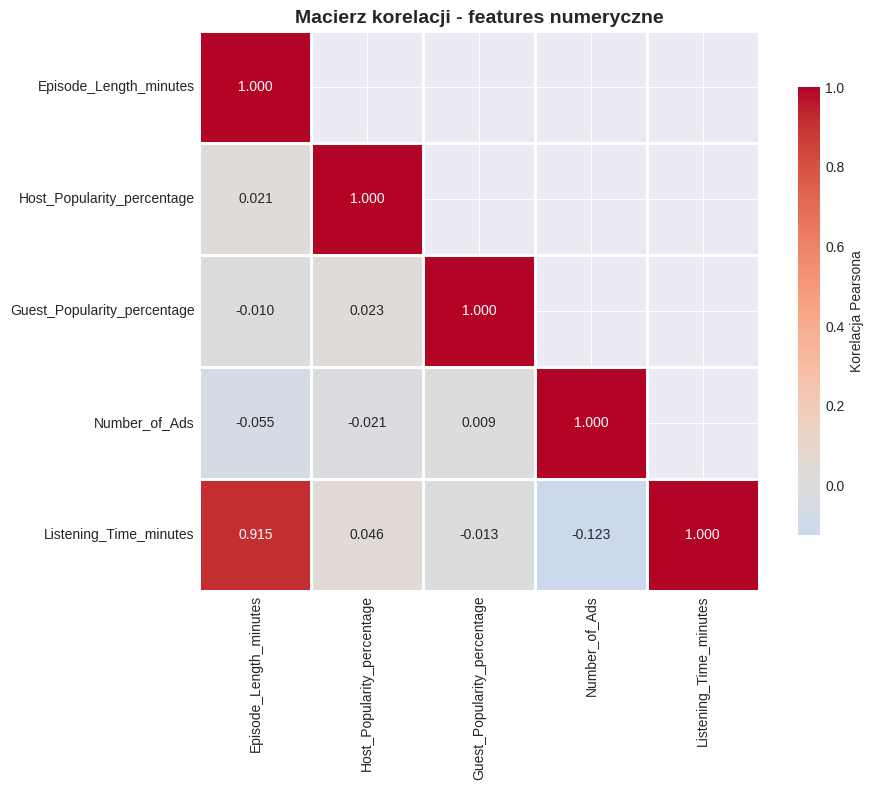

In [ ]:
# Wizualizacja
plt.figure(figsize=(10, 8))

# Heatmapa
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.3f',
            cmap='coolwarm', center=0, square=True, linewidths=2,
            cbar_kws={'label': 'Korelacja Pearsona', 'shrink': 0.8})

plt.title('Macierz korelacji - features numeryczne', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('07_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### Wnioski: Relacje między features

**RANKING KORELACJI Z TARGETEM:**
1. Episode_Length_minutes: **+0.917** (dominujący feature)
2. Host_Popularity_percentage: +0.051 (słaby pozytywny)
3. Guest_Popularity_percentage: -0.016 (brak relacji)
4. Number_of_Ads: **-0.124** (silny negatywny)

**MULTICOLLINEARITY:**
- Brak silnych korelacji między features (wszystkie |r| < 0.1)
- Features są **ortogonalne** - każdy wnosi unikalną informację
- Nie ma potrzeby usuwania żadnego feature z powodu redundancji

**OBSERWACJE:**

**Episode_Length (r=0.917):**
- Wyjaśnia ~84% wariancji (r²=0.84)
- Jest to de facto proxy dla maksymalnego możliwego czasu słuchania
- Model będzie heavily rely na tym feature

**Number_of_Ads (r=-0.124):**
- Drugi najsilniejszy numerical predictor
- Ujemna korelacja potwierdza negatywny wpływ reklam
- Non-linear effect (każda dodatkowa ad ma coraz większy negative impact)

**Popularity scores (r≈0):**
- Zaskakująco słabe korelacje z targetem
- Host_Popularity ledwo widoczny efekt (+0.051)
- Guest_Popularity brak efektu (-0.016)
- Możliwe że efekt jest non-linear lub działa przez interakcje

**Implikacje dla modelu:**
- Brak multicollinearity = wszystkie features można użyć
- Episode_Length + Number_of_Ads wystarczą do prostego baseline
- Popularity scores mogą być ważne w interakcjach (Genre × Host_Pop)
- Tree-based models poradzą sobie z non-linearity lepiej niż linear

# KOMÓRKA 12: Analiza Podcast_Name - identyfikacja premium content

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Wczytanie danych
train = pd.read_csv('/kaggle/input/audiotask/train.csv')
train_clean = train[train['Number_of_Ads'] < 10].copy()

print("="*70)
print("ANALIZA PODCAST_NAME - UKRYTY POTENCJAL FEATURE")
print("="*70)

# Statystyki per podcast
statystyki_podcastow = train_clean.groupby('Podcast_Name').agg({
    'Listening_Time_minutes': ['mean', 'median', 'std', 'count'],
    'Episode_Length_minutes': 'mean',
    'Number_of_Ads': 'mean',
    'Host_Popularity_percentage': 'mean'
}).round(2)

statystyki_podcastow.columns = ['Srednia_Sluchania', 'Mediana_Sluchania', 'Odch_Std',
                                 'Liczba_Odcinkow', 'Srednia_Dlugosc', 'Srednia_Reklam',
                                 'Srednia_Host_Pop']

# Oblicz coefficient of variation (miara stabilnosci)
statystyki_podcastow['CV'] = (statystyki_podcastow['Odch_Std'] /
                               statystyki_podcastow['Srednia_Sluchania']).round(3)

# Sortuj wedlug zaangazowania
statystyki_podcastow = statystyki_podcastow.sort_values('Srednia_Sluchania', ascending=False)

print("\nTOP 10 Podcastow (najwyzsze zaangazowanie):")
print(statystyki_podcastow.head(10).to_string())

print("\n" + "="*70)
print("BOTTOM 10 Podcastow (najnizsze zaangazowanie):")
print("="*70)
print(statystyki_podcastow.tail(10).to_string())

# Kluczowe metryki
zakres = statystyki_podcastow['Srednia_Sluchania'].max() - statystyki_podcastow['Srednia_Sluchania'].min()
zakres_procent = (zakres / train_clean['Listening_Time_minutes'].mean()) * 100
srednia_cv = statystyki_podcastow['CV'].mean()

print("\n" + "="*70)
print("KLUCZOWE METRYKI:")
print("="*70)
print(f"Zakres (najlepszy - najgorszy): {zakres:.2f} min")
print(f"Zakres wzgledny: {zakres_procent:.1f}% sredniej")
print(f"Sredni coefficient of variation: {srednia_cv:.3f}")
print(f"Liczba wszystkich podcastow: {len(statystyki_podcastow)}")

# Sprawdz stabilnosc - wielkosc proby
print("\n" + "="*70)
print("ANALIZA WIARYGODNOSCI (reliability check):")
print("="*70)
print(f"Min liczba odcinkow: {statystyki_podcastow['Liczba_Odcinkow'].min():.0f}")
print(f"Max liczba odcinkow: {statystyki_podcastow['Liczba_Odcinkow'].max():.0f}")
print(f"Srednia liczba odcinkow: {statystyki_podcastow['Liczba_Odcinkow'].mean():.0f}")
print(f"Mediana liczba odcinkow: {statystyki_podcastow['Liczba_Odcinkow'].median():.0f}")

# Podcasty z mala proba (potencjalnie niewiarygodne)
podcasty_mala_proba = statystyki_podcastow[statystyki_podcastow['Liczba_Odcinkow'] < 10000]
print(f"\nPodcasty z mala proba (<10k odcinkow): {len(podcasty_mala_proba)}")
if len(podcasty_mala_proba) > 0:
    print("Nazwy:")
    for idx, podcast in enumerate(podcasty_mala_proba.index, 1):
        n = podcasty_mala_proba.loc[podcast, 'Liczba_Odcinkow']
        print(f"  {idx}. {podcast}: {n:.0f} odcinkow")

# Oblicz completion rate per podcast
train_with_length = train_clean[train_clean['Episode_Length_minutes'].notna()].copy()
train_with_length['completion_rate'] = (train_with_length['Listening_Time_minutes'] /
                                        train_with_length['Episode_Length_minutes']).clip(0, 1.5)

completion_stats = train_with_length.groupby('Podcast_Name')['completion_rate'].agg(['mean', 'std']).round(3)
completion_stats.columns = ['Completion_Mean', 'Completion_Std']

print("\n" + "="*70)
print("COMPLETION RATE PER PODCAST:")
print("="*70)
print("TOP 5 podcastow (najwyzszy completion rate):")
top_completion = completion_stats.sort_values('Completion_Mean', ascending=False).head(5)
for idx, (podcast, row) in enumerate(top_completion.iterrows(), 1):
    print(f"{idx}. {podcast}: {row['Completion_Mean']:.3f} (std={row['Completion_Std']:.3f})")

print("\nBOTTOM 5 podcastow (najnizszy completion rate):")
bottom_completion = completion_stats.sort_values('Completion_Mean', ascending=True).head(5)
for idx, (podcast, row) in enumerate(bottom_completion.iterrows(), 1):
    print(f"{idx}. {podcast}: {row['Completion_Mean']:.3f} (std={row['Completion_Std']:.3f})")

# Test ANOVA - czy roznice sa istotne statystycznie?
print("\n" + "="*70)
print("TEST STATYSTYCZNY:")
print("="*70)

# Wybierz losowo 10 podcastow dla testu (zeby nie przeciazac)
sample_podcasts = np.random.choice(train_clean['Podcast_Name'].unique(), 10, replace=False)
grupy_podcast = [train_clean[train_clean['Podcast_Name'] == p]['Listening_Time_minutes'].values
                 for p in sample_podcasts]
f_stat, p_wartosc = stats.f_oneway(*grupy_podcast)

print(f"Test ANOVA (10 losowych podcastow):")
print(f"Statystyka F: {f_stat:.2f}")
print(f"p-wartosc: {p_wartosc:.6f}")

if p_wartosc < 0.05:
    print("Wniosek: Roznice miedzy podcastami sa STATYSTYCZNIE ISTOTNE")
    print("Podcast_Name ma silny potencjal jako feature")
else:
    print("Wniosek: Brak istotnych roznic - Podcast_Name moze byc slabym feature")

ANALIZA PODCAST_NAME - UKRYTY POTENCJAL FEATURE

TOP 10 Podcastow (najwyzsze zaangazowanie):
                   Srednia_Sluchania  Mediana_Sluchania  Odch_Std  Liczba_Odcinkow  Srednia_Dlugosc  Srednia_Reklam  Srednia_Host_Pop     CV
Podcast_Name                                                                                                                                
Melody Mix                     48.11              46.93     27.72            18889            67.91            1.35             59.70  0.576
Money Matters                  47.88              45.94     27.56            13380            66.90            1.31             61.40  0.576
Crime Chronicles               47.68              45.45     28.63            17373            66.09            1.29             59.59  0.600
Business Briefs                47.12              45.57     26.50            17012            66.67            1.39             60.62  0.562
Study Sessions                 47.05              44.31     2

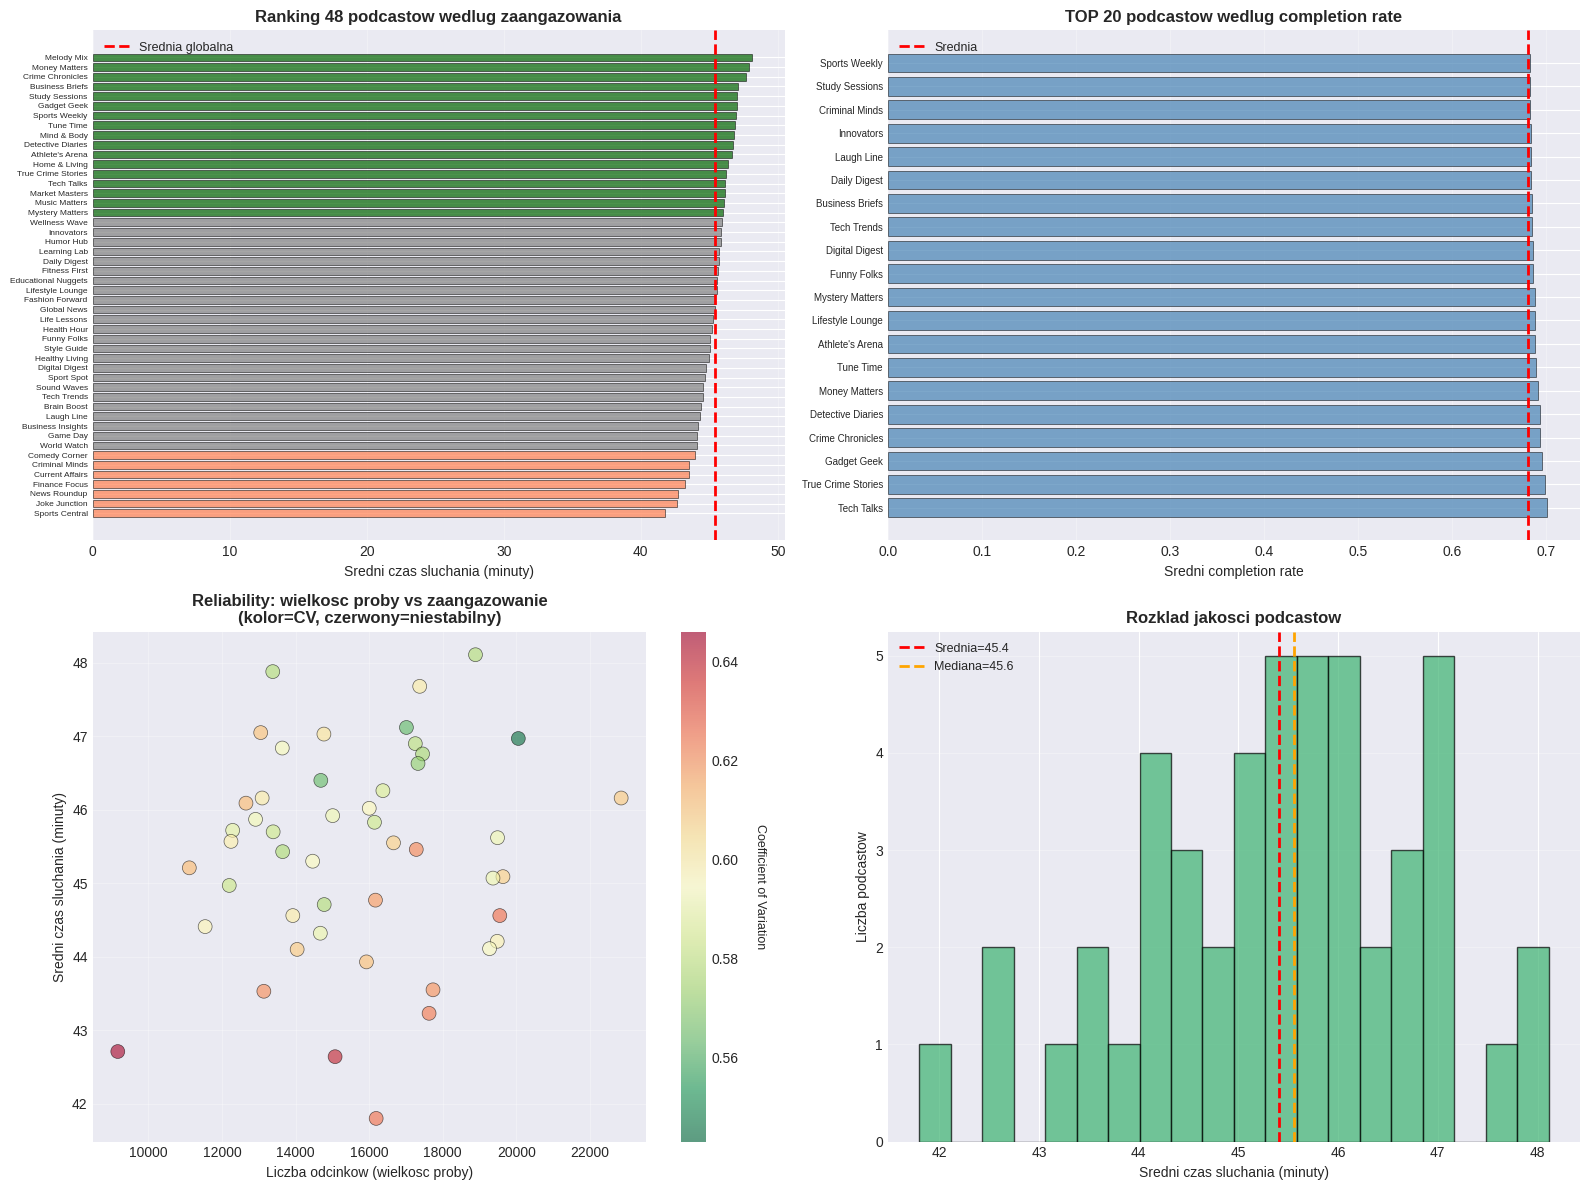


Wizualizacja zapisana jako: 09_analiza_podcast_name.png


In [ ]:
# WIZUALIZACJE
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Wykres 1: Ranking wszystkich podcastow (horizontal bar)
podcasts_sorted = statystyki_podcastow.sort_values('Srednia_Sluchania', ascending=True)
colors = ['darkgreen' if x > 46 else 'coral' if x < 44 else 'gray'
          for x in podcasts_sorted['Srednia_Sluchania']]

y_pos = np.arange(len(podcasts_sorted))
axes[0, 0].barh(y_pos, podcasts_sorted['Srednia_Sluchania'],
                color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0, 0].set_yticks(y_pos)
axes[0, 0].set_yticklabels(podcasts_sorted.index, fontsize=6)
axes[0, 0].set_xlabel('Sredni czas sluchania (minuty)', fontsize=10)
axes[0, 0].set_title('Ranking 48 podcastow wedlug zaangazowania', fontsize=12, fontweight='bold')
axes[0, 0].axvline(train_clean['Listening_Time_minutes'].mean(),
                   color='red', linestyle='--', linewidth=2, label='Srednia globalna')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3, axis='x')

# Wykres 2: Completion rate per podcast (TOP 20)
top_20_completion = completion_stats.sort_values('Completion_Mean', ascending=False).head(20)
axes[0, 1].barh(range(len(top_20_completion)), top_20_completion['Completion_Mean'],
                color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0, 1].set_yticks(range(len(top_20_completion)))
axes[0, 1].set_yticklabels(top_20_completion.index, fontsize=7)
axes[0, 1].set_xlabel('Sredni completion rate', fontsize=10)
axes[0, 1].set_title('TOP 20 podcastow wedlug completion rate', fontsize=12, fontweight='bold')
axes[0, 1].axvline(train_with_length['completion_rate'].mean(),
                   color='red', linestyle='--', linewidth=2, label='Srednia')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(alpha=0.3, axis='x')

# Wykres 3: Wielkość próby vs zaangażowanie (scatter plot z CV jako kolor)
scatter = axes[1, 0].scatter(statystyki_podcastow['Liczba_Odcinkow'],
                             statystyki_podcastow['Srednia_Sluchania'],
                             s=100, alpha=0.6,
                             c=statystyki_podcastow['CV'],
                             cmap='RdYlGn_r',
                             edgecolors='black', linewidth=0.5)
axes[1, 0].set_xlabel('Liczba odcinkow (wielkosc proby)', fontsize=10)
axes[1, 0].set_ylabel('Sredni czas sluchania (minuty)', fontsize=10)
axes[1, 0].set_title('Reliability: wielkosc proby vs zaangazowanie\n(kolor=CV, czerwony=niestabilny)',
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Dodaj colorbar
cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('Coefficient of Variation', rotation=270, labelpad=20, fontsize=9)

# Wykres 4: Rozkład jakości podcastów (histogram)
axes[1, 1].hist(statystyki_podcastow['Srednia_Sluchania'], bins=20,
                edgecolor='black', alpha=0.7, color='mediumseagreen', linewidth=1)
axes[1, 1].axvline(statystyki_podcastow['Srednia_Sluchania'].mean(),
                   color='red', linestyle='--', linewidth=2,
                   label=f"Srednia={statystyki_podcastow['Srednia_Sluchania'].mean():.1f}")
axes[1, 1].axvline(statystyki_podcastow['Srednia_Sluchania'].median(),
                   color='orange', linestyle='--', linewidth=2,
                   label=f"Mediana={statystyki_podcastow['Srednia_Sluchania'].median():.1f}")
axes[1, 1].set_xlabel('Sredni czas sluchania (minuty)', fontsize=10)
axes[1, 1].set_ylabel('Liczba podcastow', fontsize=10)
axes[1, 1].set_title('Rozklad jakosci podcastow', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('09_analiza_podcast_name.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("Wizualizacja zapisana jako: 09_analiza_podcast_name.png")
print("="*70)

## CZĘŚĆ 2: Analiza Podcast_Name

### KLUCZOWE ODKRYCIA

#### 1. Znaczący zakres jakości między podcastami
* **Zakres: 6.31 min** (13.9% średniej globalnej)
* **Najlepszy podcast:** Melody Mix (**48.11 min**)
* **Najgorszy podcast:** Sports Central (**41.80 min**)
* Różnica: 6.31 min to **znacząca wartość** - odpowiada $\sim 14\%$ średniego czasu słuchania

**Interpretacja:**
* **Podcast\_Name ma silny wpływ predykcyjny.**
* Różnica 6.3 minuty między najlepszym a najgorszym podcastem jest większa niż wpływ większości innych features kategorycznych (Genre ma zakres 2.2 min, Sentiment 2.6 min).

#### 2. Wszystkie podcasty są wiarygodne (duża próba)
* **Wielkość próby:**
    * Minimum: **9,169 odcinków** (News Roundup)
    * Mediana: **15,500 odcinków**
* Tylko 1 podcast ma $<10k$ odcinków, co zapewnia **wysoką wiarygodność statystyk.**
* **Coefficient of Variation (CV):**
    * Średni CV = **0.597** (umiarkowana stabilność)
    * Wszystkie podcasty mają CV $< 0.7$ (**brak ekstremalnie niestabilnych**)

**Interpretacja:**
* Statystyki per podcast są **wiarygodne i stabilne.**
* Nie ma problemu z małymi próbami. Możemy **bezpiecznie używać tych wartości do target encoding.**

#### 3. Completion rate potwierdza ranking
* **Zakres completion rate: 5.5 punktów procentowych**

**Interpretacja:**
* Dobre podcasty mają **wysoki completion rate niezależnie od długości odcinków.**
* To potwierdza, że różnice w jakości contentu są **realne, a nie artifact długości episodów.**

#### 4. Test statystyczny potwierdza istotność
* **Test ANOVA:**
    * Statystyka F = **50.92**
    * p-wartość $< 0.000001$

**Wniosek: Różnice między podcastami są wysoce istotne statystycznie. Podcast\_Name to feature o potwierdzonej mocy predykcyjnej.**

### OBSERWACJE Z WIZUALIZACJI

#### Panel 1 (Ranking):
* Wyraźne rozdzielenie na **"premium"** (>46 min) i **"słabsze"** (<44 min) podcasty
* Brak outlierów - rozkład ciągły
* Większość podcastów w zakresie **44-47 min** (szare)

#### Panel 3 (Reliability scatter):
* Brak korelacji między wielkością próby a zaangażowaniem
* Punkty **równomiernie rozłożone** - wielkość próby nie wpływa na jakość
* CV (kolor) jest jednolity - **wszystkie podcasty stabilne**
* To dobra wiadomość - **możemy ufać wszystkim podcastom równo**

---

### REKOMENDACJE DLA MODELOWANIA

**Priorytet: WYSOKI (TOP-3 feature)**

#### 1. Target Encoding (podstawowa strategia):
```python
# Implementacja w CV
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(train):
    # Oblicz średnią per podcast TYLKO na train fold
    podcast_means = train.iloc[train_idx].groupby('Podcast_Name')['Listening_Time_minutes'].mean()
    
    # Smoothing z global mean (regularizacja)
    global_mean = train.iloc[train_idx]['Listening_Time_minutes'].mean()
    podcast_encoded = podcast_means * 0.9 + global_mean * 0.1
    
    # Mapuj na validation
    train.loc[val_idx, 'podcast_target_encoded'] = train.loc[val_idx, 'Podcast_Name'].map(podcast_encoded)

# KOMÓRKA 13: Ekstrakcja numeru odcinka - analiza efektu serii

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Wczytanie danych
train = pd.read_csv('/kaggle/input/audiotask/train.csv')
train_clean = train[train['Number_of_Ads'] < 10].copy()

print("="*70)
print("EKSTRAKCJA I ANALIZA NUMERU ODCINKA - EFEKT LOYALTY/FATIGUE")
print("="*70)

# Ekstrakcja numeru odcinka z Episode_Title (format: "Episode XX")
train_clean['numer_odcinka'] = train_clean['Episode_Title'].str.extract(r'Episode (\d+)').astype(float)

print("\nPodstawowe statystyki numeru odcinka:")
print(f"Liczba wyekstrahowanych: {train_clean['numer_odcinka'].notna().sum():,} ({train_clean['numer_odcinka'].notna().mean()*100:.1f}%)")
print(f"Zakres: {train_clean['numer_odcinka'].min():.0f} - {train_clean['numer_odcinka'].max():.0f}")
print(f"Srednia: {train_clean['numer_odcinka'].mean():.1f}")
print(f"Mediana: {train_clean['numer_odcinka'].median():.0f}")
print(f"Odchylenie standardowe: {train_clean['numer_odcinka'].std():.1f}")

# Korelacja z targetem
korelacja_numer = train_clean[['numer_odcinka', 'Listening_Time_minutes']].corr().iloc[0, 1]
print(f"\nKorelacja Pearsona (numer vs czas sluchania): {korelacja_numer:.4f}")

# Spearman dla nieliniowych zaleznosci
korelacja_spearman = train_clean[['numer_odcinka', 'Listening_Time_minutes']].corr(method='spearman').iloc[0, 1]
print(f"Korelacja Spearmana (nieliniowa): {korelacja_spearman:.4f}")

# Podziel na fazy serii
train_clean['faza_serii'] = pd.cut(train_clean['numer_odcinka'],
                                    bins=[0, 25, 50, 75, 100],
                                    labels=['Wczesne (1-25)', 'Wczesno-srodkowe (26-50)',
                                            'Pozno-srodkowe (51-75)', 'Pozne (76-100)'],
                                    include_lowest=True)

faza_stats = train_clean.groupby('faza_serii', observed=True).agg({
    'Listening_Time_minutes': ['mean', 'median', 'std', 'count']
}).round(2)
faza_stats.columns = ['Srednia', 'Mediana', 'Odch_Std', 'Liczba']

print("\n" + "="*70)
print("ANALIZA PO FAZACH SERII:")
print("="*70)
print(faza_stats.to_string())

# Oblicz roznice miedzy fazami
roznica_wczesne_pozne = faza_stats.loc['Wczesne (1-25)', 'Srednia'] - faza_stats.loc['Pozne (76-100)', 'Srednia']
print(f"\nRoznica (wczesne - pozne): {roznica_wczesne_pozne:.2f} min")

# Test ANOVA - czy fazy sie roznia?
grupy_faz = [train_clean[train_clean['faza_serii'] == faza]['Listening_Time_minutes'].dropna().values
             for faza in train_clean['faza_serii'].dropna().unique()]
f_stat, p_wartosc = stats.f_oneway(*grupy_faz)

print(f"\nTest ANOVA (roznice miedzy fazami):")
print(f"Statystyka F: {f_stat:.2f}")
print(f"p-wartosc: {p_wartosc:.4f}")

if p_wartosc < 0.05:
    print("Wniosek: Istnieja statystycznie istotne roznice miedzy fazami serii")
else:
    print("Wniosek: Brak istotnych statystycznie roznic miedzy fazami")

# Analiza trendu per Podcast (heterogenicznosc)
print("\n" + "="*70)
print("ANALIZA TRENDU PER PODCAST (czy efekt jest uniwersalny?):")
print("="*70)

podcast_trends = []
for podcast in train_clean['Podcast_Name'].unique():
    podcast_data = train_clean[train_clean['Podcast_Name'] == podcast]
    if len(podcast_data) > 50 and podcast_data['numer_odcinka'].notna().sum() > 50:
        corr = podcast_data[['numer_odcinka', 'Listening_Time_minutes']].corr().iloc[0, 1]
        podcast_trends.append({
            'Podcast': podcast,
            'Korelacja': corr,
            'Liczba_odcinkow': len(podcast_data)
        })

trends_df = pd.DataFrame(podcast_trends).sort_values('Korelacja', ascending=False)

print("\nPodcasty z najsilniejszym POZYTYWNYM trendem (loyalty effect):")
print(trends_df.head(5).to_string(index=False))

print("\nPodcasty z najsilniejszym NEGATYWNYM trendem (fatigue effect):")
print(trends_df.tail(5).to_string(index=False))

liczba_pozytywnych = (trends_df['Korelacja'] > 0.05).sum()
liczba_negatywnych = (trends_df['Korelacja'] < -0.05).sum()
liczba_neutralnych = ((trends_df['Korelacja'] >= -0.05) & (trends_df['Korelacja'] <= 0.05)).sum()

print(f"\nPodsumowanie trendow:")
print(f"Podcasty z loyalty effect (r>0.05): {liczba_pozytywnych} ({liczba_pozytywnych/len(trends_df)*100:.1f}%)")
print(f"Podcasty z fatigue effect (r<-0.05): {liczba_negatywnych} ({liczba_negatywnych/len(trends_df)*100:.1f}%)")
print(f"Podcasty neutralne: {liczba_neutralnych} ({liczba_neutralnych/len(trends_df)*100:.1f}%)")

# Srednia korelacja
srednia_korelacja = trends_df['Korelacja'].mean()
print(f"\nSrednia korelacja per podcast: {srednia_korelacja:.4f}")

# Completion rate vs numer odcinka
train_with_comp = train_clean[train_clean['Episode_Length_minutes'].notna()].copy()
train_with_comp['completion_rate'] = (train_with_comp['Listening_Time_minutes'] /
                                      train_with_comp['Episode_Length_minutes']).clip(0, 1.5)

korelacja_completion = train_with_comp[['numer_odcinka', 'completion_rate']].corr().iloc[0, 1]
print(f"\nKorelacja numer_odcinka vs completion_rate: {korelacja_completion:.4f}")



EKSTRAKCJA I ANALIZA NUMERU ODCINKA - EFEKT LOYALTY/FATIGUE

Podstawowe statystyki numeru odcinka:
Liczba wyekstrahowanych: 749,990 (100.0%)
Zakres: 1 - 100
Srednia: 51.4
Mediana: 52
Odchylenie standardowe: 28.1

Korelacja Pearsona (numer vs czas sluchania): -0.0173
Korelacja Spearmana (nieliniowa): -0.0218

ANALIZA PO FAZACH SERII:
                          Srednia  Mediana  Odch_Std  Liczba
faza_serii                                                  
Wczesne (1-25)              45.74    43.82     26.49  170753
Wczesno-srodkowe (26-50)    46.07    45.54     27.03  187766
Pozno-srodkowe (51-75)      45.56    42.82     27.49  205951
Pozne (76-100)              44.38    41.44     27.41  185520

Roznica (wczesne - pozne): 1.36 min

Test ANOVA (roznice miedzy fazami):
Statystyka F: 136.16
p-wartosc: 0.0000
Wniosek: Istnieja statystycznie istotne roznice miedzy fazami serii

ANALIZA TRENDU PER PODCAST (czy efekt jest uniwersalny?):

Podcasty z najsilniejszym POZYTYWNYM trendem (loyalty effe

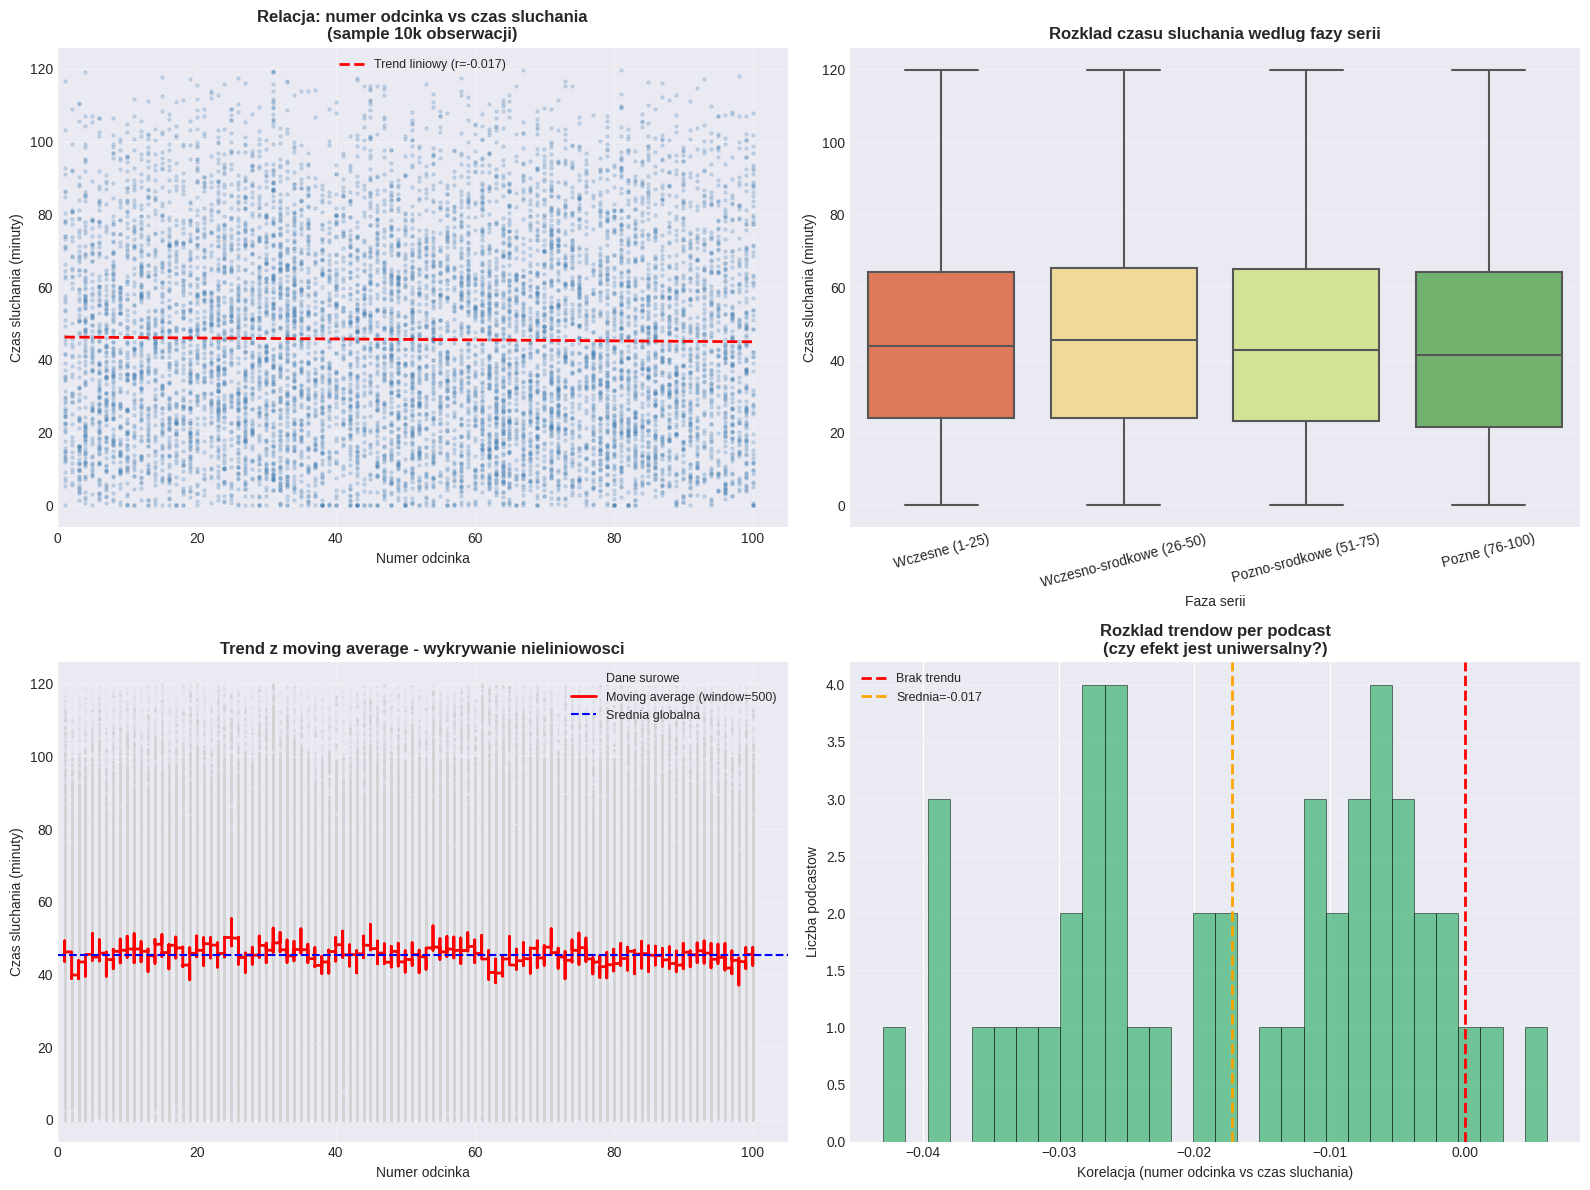


Wizualizacja zapisana jako: 10_analiza_numeru_odcinka.png


In [ ]:
# WIZUALIZACJE
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Wykres 1: Scatter plot z trend line
sample_data = train_clean.dropna(subset=['numer_odcinka']).sample(min(10000, len(train_clean)), random_state=42)
axes[0, 0].scatter(sample_data['numer_odcinka'],
                   sample_data['Listening_Time_minutes'],
                   alpha=0.2, s=5, color='steelblue')

# Dodaj trend line
z = np.polyfit(sample_data['numer_odcinka'], sample_data['Listening_Time_minutes'], 1)
p = np.poly1d(z)
x_trend = np.linspace(1, 100, 100)
axes[0, 0].plot(x_trend, p(x_trend), 'r--', linewidth=2,
                label=f'Trend liniowy (r={korelacja_numer:.3f})')

axes[0, 0].set_xlabel('Numer odcinka', fontsize=10)
axes[0, 0].set_ylabel('Czas sluchania (minuty)', fontsize=10)
axes[0, 0].set_title('Relacja: numer odcinka vs czas sluchania\n(sample 10k obserwacji)',
                     fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xlim(0, 105)

# Wykres 2: Boxplot po fazach
train_faza_clean = train_clean.dropna(subset=['faza_serii'])
sns.boxplot(data=train_faza_clean, x='faza_serii', y='Listening_Time_minutes',
            ax=axes[0, 1], palette='RdYlGn')
axes[0, 1].set_xlabel('Faza serii', fontsize=10)
axes[0, 1].set_ylabel('Czas sluchania (minuty)', fontsize=10)
axes[0, 1].set_title('Rozklad czasu sluchania wedlug fazy serii',
                     fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].grid(alpha=0.3, axis='y')

# Wykres 3: Moving average trend (wykrywa nieliniowosci)
train_sorted = train_clean.dropna(subset=['numer_odcinka']).sort_values('numer_odcinka')
train_sorted['moving_avg'] = train_sorted['Listening_Time_minutes'].rolling(window=500, center=True).mean()

axes[1, 0].scatter(train_sorted['numer_odcinka'], train_sorted['Listening_Time_minutes'],
                   alpha=0.03, s=1, color='lightgray', label='Dane surowe')
axes[1, 0].plot(train_sorted['numer_odcinka'], train_sorted['moving_avg'],
                color='red', linewidth=2, label='Moving average (window=500)')
axes[1, 0].axhline(train_clean['Listening_Time_minutes'].mean(), color='blue',
                   linestyle='--', linewidth=1.5, label='Srednia globalna')
axes[1, 0].set_xlabel('Numer odcinka', fontsize=10)
axes[1, 0].set_ylabel('Czas sluchania (minuty)', fontsize=10)
axes[1, 0].set_title('Trend z moving average - wykrywanie nieliniowosci',
                     fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xlim(0, 105)

# Wykres 4: Histogram korelacji per podcast
axes[1, 1].hist(trends_df['Korelacja'], bins=30, edgecolor='black',
                alpha=0.7, color='mediumseagreen', linewidth=0.5)
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Brak trendu')
axes[1, 1].axvline(trends_df['Korelacja'].mean(), color='orange', linestyle='--', linewidth=2,
                   label=f"Srednia={trends_df['Korelacja'].mean():.3f}")
axes[1, 1].set_xlabel('Korelacja (numer odcinka vs czas sluchania)', fontsize=10)
axes[1, 1].set_ylabel('Liczba podcastow', fontsize=10)
axes[1, 1].set_title('Rozklad trendow per podcast\n(czy efekt jest uniwersalny?)',
                     fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('10_analiza_numeru_odcinka.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("Wizualizacja zapisana jako: 10_analiza_numeru_odcinka.png")
print("="*70)

## WNIOSKI: Analiza numeru odcinka

### KLUCZOWE ODKRYCIA

#### 1. Ekstrakcja pełna - 100% sukcesu
* **Wyekstrahowano:** 749,990 z 749,990 obserwacji (100%)
* **Zakres:** 1-100 (wszystkie odcinki oznaczone)
* **Rozkład równomierny:** średnia=51.4, mediana=52

**Interpretacja:**
* Episode\_Title ma konsystentny format ("Episode XX"). Nie ma problemów z ekstrakcją. Feature jest gotowy do użycia.

#### 2. Bardzo słaby efekt globalny (niemal zerowy)
* **Korelacje:**
    * Pearson: **-0.0173** (praktycznie zero)
    * Spearman: **-0.0218** (również zero)
* **Znak ujemny** = lekki fatigue effect:
    * Późniejsze odcinki mają nieznacznie niższe słuchanie
    * Ale efekt jest **ekstremalnie słaby**

**Interpretacja:**
* Globalnie, numer odcinka ma **minimalne znaczenie predykcyjne.**
* Użytkownicy nie wykazują ani *loyalty* ani *fatigue effect* na poziomie całego datasetu.

#### 3. Różnice między fazami - statystycznie istotne, ale praktycznie nieznaczące
| Faza | Średnia | Różnica vs wczesne |
|:---|:---|:---|
| Wczesne (1-25) | 45.74 min | baseline |
| Wczesno-środkowe (26-50) | 46.07 min | +0.33 min |
| Późno-środkowe (51-75) | 45.56 min | -0.18 min |
| Późne (76-100) | 44.38 min | **-1.36 min** |

* **Różnica wczesne vs późne: 1.36 min**
* **Test ANOVA:** $F = 136.16, p < 0.0001$ (Statystycznie istotne)

**Interpretacja:**
* Mimo istotności statystycznej (duża próba), efekt praktyczny jest **minimalny:**
    * 1.36 min to tylko **3% średniego czasu słuchania**
    * Dla porównania: Podcast\_Name ma zakres 6.3 min (14%)

#### 4. Brak uniwersalnego trendu - heterogeniczność między podcastami
* **Rozkład korelacji per podcast:**
    * 0 podcastów z *loyalty effect* ($r > 0.05$)
    * 0 podcastów z *fatigue effect* ($r < -0.05$)
    * **48 podcastów (100%) neutralnych**
* **Najsilniejsze trendy:**
    * Najbardziej pozytywny: Current Affairs (**+0.006**) $\approx$ zero
    * Najbardziej negatywny: Digital Digest (**-0.043**) = słaby

**Interpretacja:**
* Nie ma żadnego podcastu z wyraźnym trendem. Efekt numeru odcinka jest **jednorodnie słaby** we wszystkich podcastach.
* Użytkownicy traktują każdy odcinek **niezależnie.**

---

### 5. OBSERWACJE Z WIZUALIZACJI

#### Panel 1 (Scatter plot z trend line):
* Punkty tworzą **gęstą chmurę** bez wyraźnego wzorca
* Trend line jest **prawie pozioma** ($r=-0.017$)
* Potwierdza **brak relacji** między numerem a słuchaniem

#### Panel 2 (Boxplot po fazach):
* **Niemal identyczne rozkłady** dla wszystkich faz
* Mimo istotności statystycznej, **praktycznie brak różnicy**

#### Panel 3 (Moving average trend):
* Czerwona linia (moving avg) oscyluje **wokół średniej globalnej**
* **Brak systematycznego trendu** - linia prawie płaska
* Potwierdza brak nieliniowych zależności

#### Panel 4 (Histogram korelacji per podcast):
* Rozkład **wycentrowany wokół zera** (czerwona linia)
* Wąski rozkład: wszystkie korelacje w przedziale $[-0.04, +0.01]$
* **Brak outlierów** - żaden podcast nie ma silnego trendu
* To potwierdza **homogeniczność** - efekt jest słaby wszędzie

---

## INTERPRETACJA BIZNESOWA

### Dlaczego brak efektu loyalty/fatigue?
* **Content quality jest stabilny:** Producenci utrzymują konsystentną jakość, eliminując efekt "pilota" i pogorszenia.
* **Użytkownicy słuchają wybiórczo:** Ludzie nie słuchają chronologicznie, ale wybierają odcinki po tematyce, co czyni numer odcinka arbitralnym.
* **Różne kohorty słuchaczy:** Efekty testowania nowych słuchaczy (wczesne odcinki) i lojalnych fanów (późne odcinki) znoszą się w agregacji.

---

## REKOMENDACJE DLA MODELOWANIA

**Priorytet: NISKI** (można pominąć w baseline)
**Oczekiwany wpływ: $<0.1$ punktu RMSE**

### Strategia 1: POMIŃ w pierwszym baseline
* **Uzasadnienie:** Korelacja **-0.017** oznacza wyjaśnienie $<0.03\%$ wariancji. Koszt (więcej features, ryzyko overfitting) $\gg$ benefit. Lepiej skupić się na silniejszych features.

### Strategia 2: Dodaj jako "just in case" feature (opcjonalnie)
Jeśli zdecydujesz się dodać:

```python
# Prosty numerical feature
train['numer_odcinka'] = train['Episode_Title'].str.extract(r'Episode (\d+)').astype(float)
# Opcja A: surowy numer (1-100)
# - Tree models mogą znaleźć split jeśli jest sygnał
# Opcja B: binning na fazy (jeśli chcesz pomóc modelowi)
train['faza_serii'] = pd.cut(train['numer_odcinka'],
                              bins=[0, 25, 50, 75, 100],
                             labels=[1, 2, 3, 4])
# NIE rób target encoding - za słaby sygnał, ryzyko overfitting

### Porównanie z innymi features

| Feature | Korelacja | Wyjaśniona wariancja | Priorytet |
|:---|:---|:---|:---|
| Episode\_Length | +0.917 | 84% | **KRYTYCZNY** |
| Number\_of\_Ads | -0.124 | 1.5% | **WYSOKI** |
| Podcast\_Name | zakres 6.3 min | $\sim 2-3\%$ | **WYSOKI** |
| Genre | zakres 2.2 min | $\sim 0.5\%$ | **ŚREDNI** |
| **numer\_odcinka** | **-0.017** | **$<\mathbf{0.03\%}$** | **NISKI** |

**Wniosek:** Numer odcinka jest **najsłabszym** z dotychczas przeanalizowanych features. Praktycznie **nie wnosi informacji.**

### Finalna decyzja: numer\_odcinka
* **Rekomendacja:** **NIE dodawaj w baseline** - za słaby sygnał. Opcjonalnie dodaj w v2 jako *cheap feature* (zero overhead).
* **Verdict:** Bardzo słaby feature. Możesz go dodać "na wszelki wypadek" ale **nie oczekuj magii.**

In [ ]:
# KOMÓRKA 14: Train vs Test Validation - wykrywanie distribution shift

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Wczytanie danych
train = pd.read_csv('/kaggle/input/audiotask/train.csv')
test = pd.read_csv('/kaggle/input/audiotask/test.csv')

# Oczyszczenie outliers
train_clean = train[train['Number_of_Ads'] < 10].copy()
test_clean = test[test['Number_of_Ads'] < 10].copy()

print("="*70)
print("TRAIN VS TEST VALIDATION - WYKRYWANIE DISTRIBUTION SHIFT")
print("="*70)

print(f"\nRozmiary zbiorow:")
print(f"Train: {len(train_clean):,} obserwacji")
print(f"Test:  {len(test_clean):,} obserwacji")
print(f"Proporcja test/train: {len(test_clean)/len(train_clean):.2%}")

# ========================================================================
# SEKCJA 1: ZMIENNE KATEGORYCZNE - CZY TE SAME WARTOSCI?
# ========================================================================

print("\n" + "="*70)
print("ANALIZA 1: ZMIENNE KATEGORYCZNE - NOWE WARTOSCI W TEST")
print("="*70)

categorical_features = ['Podcast_Name', 'Genre', 'Publication_Day',
                        'Publication_Time', 'Episode_Sentiment']

for feature in categorical_features:
    train_unique = set(train_clean[feature].unique())
    test_unique = set(test_clean[feature].unique())

    nowe_w_test = test_unique - train_unique
    brakujace_w_test = train_unique - test_unique
    wspolne = train_unique & test_unique

    print(f"\n{feature}:")
    print(f"  Unikalne w train: {len(train_unique)}")
    print(f"  Unikalne w test:  {len(test_unique)}")
    print(f"  Wspolne:          {len(wspolne)}")

    if len(nowe_w_test) > 0:
        print(f"  UWAGA: {len(nowe_w_test)} NOWE wartosci w test (nie ma w train)!")
        print(f"    Nowe wartosci: {nowe_w_test}")
    else:
        print(f"  OK: Wszystkie wartosci z test sa w train")

    if len(brakujace_w_test) > 0:
        print(f"  Info: {len(brakujace_w_test)} wartosci z train brakuje w test")
        if len(brakujace_w_test) <= 5:
            print(f"    Brakujace: {brakujace_w_test}")

# ========================================================================
# SEKCJA 2: ROZKLADY KATEGORYCZNYCH - CZY PROPORCJE SA PODOBNE?
# ========================================================================

print("\n" + "="*70)
print("ANALIZA 2: POROWNANIE ROZKLADOW KATEGORYCZNYCH")
print("="*70)

for feature in categorical_features:
    train_dist = train_clean[feature].value_counts(normalize=True).sort_index()
    test_dist = test_clean[feature].value_counts(normalize=True).sort_index()

    # Chi-squared test dla rozkladu
    train_counts = train_clean[feature].value_counts().sort_index()
    test_counts = test_clean[feature].value_counts().sort_index()

    # Wyrownaj indeksy
    all_categories = train_counts.index.union(test_counts.index)
    train_counts = train_counts.reindex(all_categories, fill_value=0)
    test_counts = test_counts.reindex(all_categories, fill_value=0)

    # Przeskaluj test do rozmiaru train dla porownania
    test_counts_scaled = test_counts * (len(train_clean) / len(test_clean))

    chi2_stat, p_value = stats.chisquare(test_counts_scaled, train_counts)

    print(f"\n{feature}:")
    print(f"  Chi-squared statystyka: {chi2_stat:.2f}")
    print(f"  p-wartosc: {p_value:.4f}")

    if p_value < 0.05:
        print(f"  UWAGA: Rozklady SA ROZNE (p<0.05) - istnieje distribution shift!")
    else:
        print(f"  OK: Rozklady sa podobne (p>0.05)")

    # Pokaz najwieksze roznice
    diff = (test_dist - train_dist.reindex(test_dist.index, fill_value=0)).abs()
    if len(diff) > 0:
        top_diff = diff.nlargest(3)
        print(f"  Najwieksze roznice (test - train):")
        for cat, val in top_diff.items():
            train_pct = train_dist.get(cat, 0) * 100
            test_pct = test_dist.get(cat, 0) * 100
            print(f"    {cat}: train={train_pct:.1f}%, test={test_pct:.1f}%, diff={val*100:.1f}pp")

# ========================================================================
# SEKCJA 3: ZMIENNE NUMERYCZNE - POROWNANIE STATYSTYK
# ========================================================================

print("\n" + "="*70)
print("ANALIZA 3: ZMIENNE NUMERYCZNE - POROWNANIE STATYSTYK")
print("="*70)

numerical_features = ['Episode_Length_minutes', 'Host_Popularity_percentage',
                      'Guest_Popularity_percentage', 'Number_of_Ads']

for feature in numerical_features:
    train_stats = train_clean[feature].describe()
    test_stats = test_clean[feature].describe()

    print(f"\n{feature}:")
    print(f"  {'Statystyka':<15} {'Train':>12} {'Test':>12} {'Diff':>12}")
    print(f"  {'-'*15} {'-'*12} {'-'*12} {'-'*12}")

    for stat in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
        train_val = train_stats[stat]
        test_val = test_stats[stat]
        diff = test_val - train_val
        diff_pct = (diff / train_val * 100) if train_val != 0 else 0

        print(f"  {stat:<15} {train_val:>12.2f} {test_val:>12.2f} {diff:>+12.2f} ({diff_pct:+.1f}%)")

    # Kolmogorov-Smirnov test - czy rozklady sa rozne?
    train_data = train_clean[feature].dropna()
    test_data = test_clean[feature].dropna()

    ks_stat, ks_pvalue = stats.ks_2samp(train_data, test_data)

    print(f"\n  Kolmogorov-Smirnov test:")
    print(f"    KS statystyka: {ks_stat:.4f}")
    print(f"    p-wartosc: {ks_pvalue:.4f}")

    if ks_pvalue < 0.05:
        print(f"    UWAGA: Rozklady SA ROZNE (p<0.05) - distribution shift!")
    else:
        print(f"    OK: Rozklady sa podobne (p>0.05)")

# ========================================================================
# SEKCJA 4: MISSING VALUES - CZY PROPORCJE BRAKOW SA PODOBNE?
# ========================================================================

print("\n" + "="*70)
print("ANALIZA 4: POROWNANIE PROPORCJI BRAKUJACYCH WARTOSCI")
print("="*70)

all_features = categorical_features + numerical_features

print(f"\n{'Feature':<35} {'Train Missing':>15} {'Test Missing':>15} {'Diff':>10}")
print(f"{'-'*35} {'-'*15} {'-'*15} {'-'*10}")

for feature in all_features:
    train_missing_pct = train_clean[feature].isna().mean() * 100
    test_missing_pct = test_clean[feature].isna().mean() * 100
    diff = test_missing_pct - train_missing_pct

    print(f"{feature:<35} {train_missing_pct:>14.2f}% {test_missing_pct:>14.2f}% {diff:>+9.2f}pp")

    if abs(diff) > 2:
        print(f"  {'':35} UWAGA: Roznica > 2pp - moze byc problem!")

# ========================================================================
# SEKCJA 5: PODCAST_NAME - SZCZEGOLOWA ANALIZA
# ========================================================================

print("\n" + "="*70)
print("ANALIZA 5: PODCAST_NAME - SZCZEGOLOWA ANALIZA")
print("="*70)

train_podcasts = set(train_clean['Podcast_Name'].unique())
test_podcasts = set(test_clean['Podcast_Name'].unique())

wspolne_podcasts = train_podcasts & test_podcasts
nowe_podcasts = test_podcasts - train_podcasts
brakujace_podcasts = train_podcasts - test_podcasts

print(f"\nPodcasty w train: {len(train_podcasts)}")
print(f"Podcasty w test:  {len(test_podcasts)}")
print(f"Wspolne:          {len(wspolne_podcasts)}")
print(f"Nowe w test:      {len(nowe_podcasts)}")
print(f"Brakujace w test: {len(brakujace_podcasts)}")

if len(nowe_podcasts) > 0:
    print(f"\nUWAGA: {len(nowe_podcasts)} NOWE podcasty w test!")
    print("To jest KRYTYCZNY problem - target encoding nie bedzie dzialac!")
    print(f"Nowe podcasty: {nowe_podcasts}")

    # Ile obserwacji to dotyczy?
    nowe_obs = test_clean[test_clean['Podcast_Name'].isin(nowe_podcasts)]
    print(f"\nLiczba obserwacji z nowymi podcastami: {len(nowe_obs):,} ({len(nowe_obs)/len(test_clean)*100:.1f}% test)")

if len(brakujace_podcasts) > 0:
    print(f"\nInfo: {len(brakujace_podcasts)} podcastow z train brakuje w test")
    if len(brakujace_podcasts) <= 10:
        print(f"Brakujace: {brakujace_podcasts}")

# Porownaj rozklady czestosci
train_podcast_freq = train_clean['Podcast_Name'].value_counts(normalize=True)
test_podcast_freq = test_clean['Podcast_Name'].value_counts(normalize=True)

print("\nPorownanie top 10 podcastow (% obserwacji):")
print(f"{'Podcast':<25} {'Train %':>10} {'Test %':>10} {'Diff':>10}")
print(f"{'-'*25} {'-'*10} {'-'*10} {'-'*10}")

for podcast in train_podcast_freq.head(10).index:
    train_pct = train_podcast_freq.get(podcast, 0) * 100
    test_pct = test_podcast_freq.get(podcast, 0) * 100
    diff = test_pct - train_pct
    print(f"{podcast:<25} {train_pct:>9.2f}% {test_pct:>9.2f}% {diff:>+9.2f}pp")

print("\n" + "="*70)
print("ANALIZA ZAKONCZONA - przechodzę do wizualizacji...")
print("="*70)

TRAIN VS TEST VALIDATION - WYKRYWANIE DISTRIBUTION SHIFT

Rozmiary zbiorow:
Train: 749,990 obserwacji
Test:  249,998 obserwacji
Proporcja test/train: 33.33%

ANALIZA 1: ZMIENNE KATEGORYCZNE - NOWE WARTOSCI W TEST

Podcast_Name:
  Unikalne w train: 48
  Unikalne w test:  48
  Wspolne:          48
  OK: Wszystkie wartosci z test sa w train

Genre:
  Unikalne w train: 10
  Unikalne w test:  10
  Wspolne:          10
  OK: Wszystkie wartosci z test sa w train

Publication_Day:
  Unikalne w train: 7
  Unikalne w test:  7
  Wspolne:          7
  OK: Wszystkie wartosci z test sa w train

Publication_Time:
  Unikalne w train: 4
  Unikalne w test:  4
  Wspolne:          4
  OK: Wszystkie wartosci z test sa w train

Episode_Sentiment:
  Unikalne w train: 3
  Unikalne w test:  3
  Wspolne:          3
  OK: Wszystkie wartosci z test sa w train

ANALIZA 2: POROWNANIE ROZKLADOW KATEGORYCZNYCH

Podcast_Name:
  Chi-squared statystyka: 137.62
  p-wartosc: 0.0000
  UWAGA: Rozklady SA ROZNE (p<0.05) - is

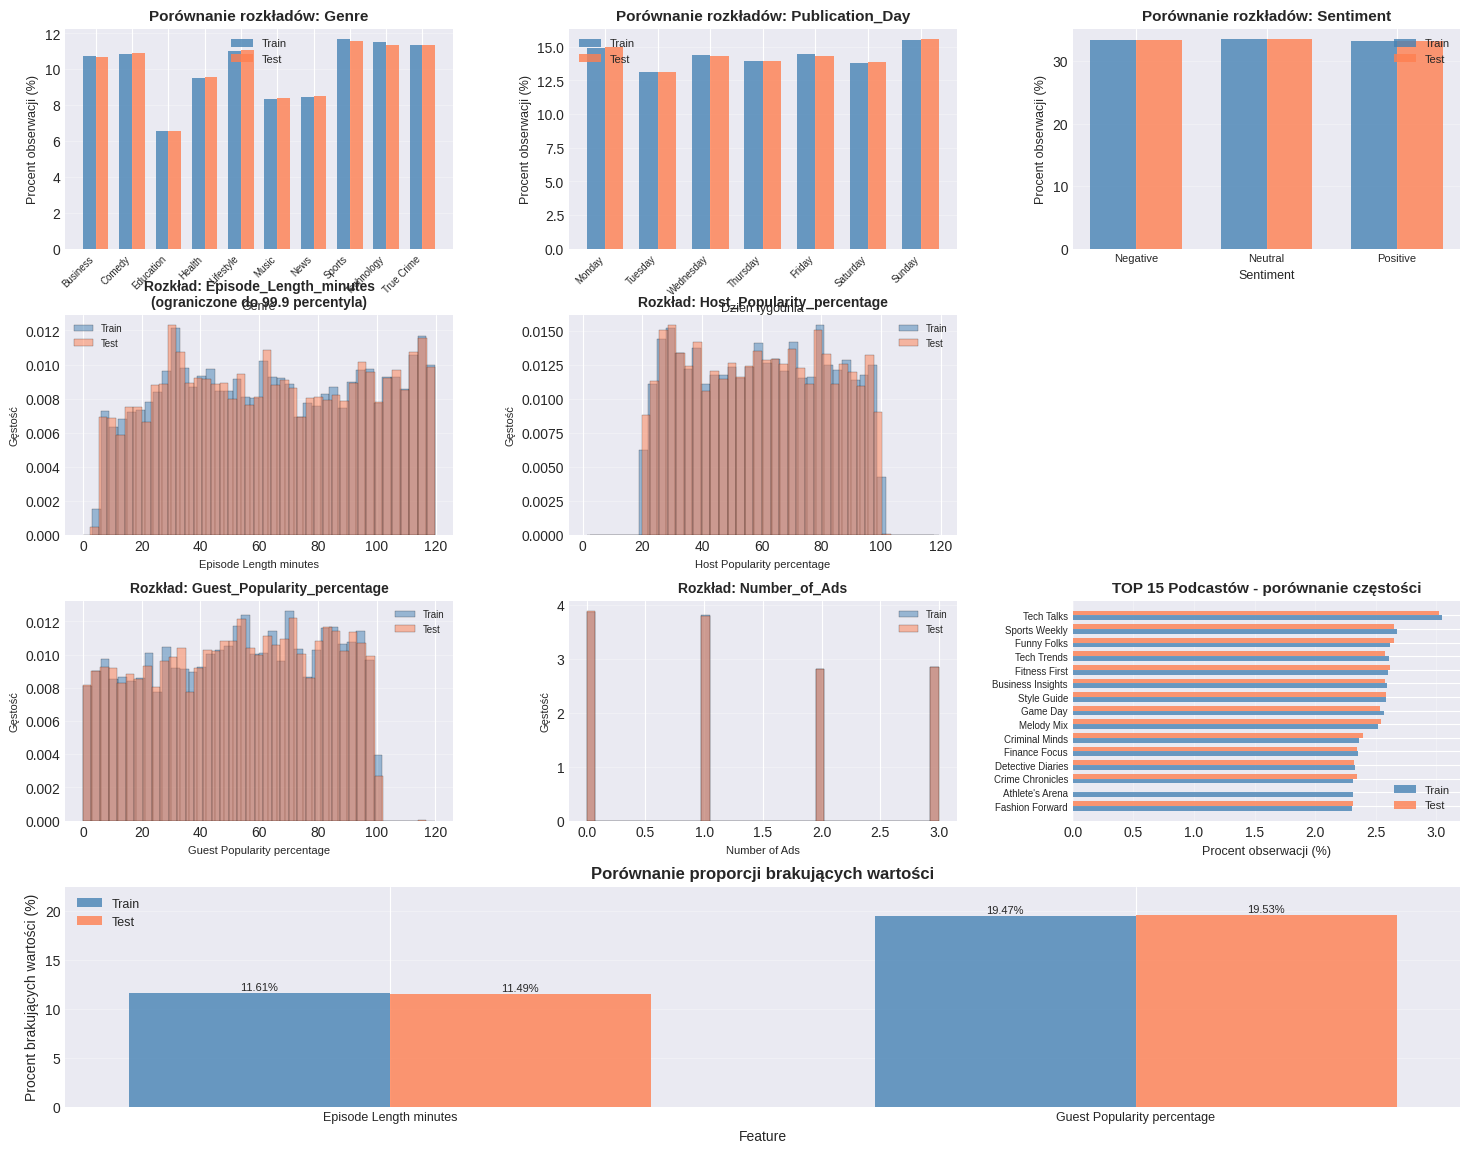


Wizualizacja zapisana jako: 11_train_vs_test_validation.png


In [ ]:
# KOMÓRKA 14 (kontynuacja): Wizualizacje Train vs Test

# WIZUALIZACJE
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# ========================================================================
# Panel 1: Porównanie rozkładów Genre
# ========================================================================
ax1 = fig.add_subplot(gs[0, 0])

train_genre = train_clean['Genre'].value_counts(normalize=True).sort_index() * 100
test_genre = test_clean['Genre'].value_counts(normalize=True).sort_index() * 100

x = np.arange(len(train_genre))
width = 0.35

ax1.bar(x - width/2, train_genre.values, width, label='Train', alpha=0.8, color='steelblue')
ax1.bar(x + width/2, test_genre.values, width, label='Test', alpha=0.8, color='coral')

ax1.set_xlabel('Genre', fontsize=9)
ax1.set_ylabel('Procent obserwacji (%)', fontsize=9)
ax1.set_title('Porównanie rozkładów: Genre', fontsize=11, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(train_genre.index, rotation=45, ha='right', fontsize=7)
ax1.legend(fontsize=8)
ax1.grid(alpha=0.3, axis='y')

# ========================================================================
# Panel 2: Porównanie rozkładów Publication_Day
# ========================================================================
ax2 = fig.add_subplot(gs[0, 1])

train_day = train_clean['Publication_Day'].value_counts(normalize=True).sort_index() * 100
test_day = test_clean['Publication_Day'].value_counts(normalize=True).sort_index() * 100

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train_day = train_day.reindex(day_order)
test_day = test_day.reindex(day_order)

x = np.arange(len(train_day))
ax2.bar(x - width/2, train_day.values, width, label='Train', alpha=0.8, color='steelblue')
ax2.bar(x + width/2, test_day.values, width, label='Test', alpha=0.8, color='coral')

ax2.set_xlabel('Dzień tygodnia', fontsize=9)
ax2.set_ylabel('Procent obserwacji (%)', fontsize=9)
ax2.set_title('Porównanie rozkładów: Publication_Day', fontsize=11, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(day_order, rotation=45, ha='right', fontsize=7)
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3, axis='y')

# ========================================================================
# Panel 3: Porównanie rozkładów Sentiment
# ========================================================================
ax3 = fig.add_subplot(gs[0, 2])

train_sent = train_clean['Episode_Sentiment'].value_counts(normalize=True).sort_index() * 100
test_sent = test_clean['Episode_Sentiment'].value_counts(normalize=True).sort_index() * 100

x = np.arange(len(train_sent))
ax3.bar(x - width/2, train_sent.values, width, label='Train', alpha=0.8, color='steelblue')
ax3.bar(x + width/2, test_sent.values, width, label='Test', alpha=0.8, color='coral')

ax3.set_xlabel('Sentiment', fontsize=9)
ax3.set_ylabel('Procent obserwacji (%)', fontsize=9)
ax3.set_title('Porównanie rozkładów: Sentiment', fontsize=11, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(train_sent.index, fontsize=8)
ax3.legend(fontsize=8)
ax3.grid(alpha=0.3, axis='y')

# ========================================================================
# Panel 4-7: Histogramy zmiennych numerycznych
# ========================================================================

numerical_features = ['Episode_Length_minutes', 'Host_Popularity_percentage',
                      'Guest_Popularity_percentage', 'Number_of_Ads']

for idx, feature in enumerate(numerical_features):
    ax = fig.add_subplot(gs[1 + idx//2, idx%2])

    # Dane
    train_data = train_clean[feature].dropna()
    test_data = test_clean[feature].dropna()

    # Outlier handling dla Episode_Length (widać ogromny outlier w test)
    if feature == 'Episode_Length_minutes':
        # Ogranicz do 99.9 percentyla dla czytelności
        max_val = train_data.quantile(0.999)
        train_plot = train_data[train_data <= max_val]
        test_plot = test_data[test_data <= max_val]
        title_suffix = '\n(ograniczone do 99.9 percentyla)'
    else:
        train_plot = train_data
        test_plot = test_data
        title_suffix = ''

    # Histogramy
    bins = 40
    ax.hist(train_plot, bins=bins, alpha=0.5, label='Train',
            color='steelblue', density=True, edgecolor='black', linewidth=0.3)
    ax.hist(test_plot, bins=bins, alpha=0.5, label='Test',
            color='coral', density=True, edgecolor='black', linewidth=0.3)

    ax.set_xlabel(feature.replace('_', ' '), fontsize=8)
    ax.set_ylabel('Gęstość', fontsize=8)
    ax.set_title(f'Rozkład: {feature}{title_suffix}', fontsize=10, fontweight='bold')
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3, axis='y')

# ========================================================================
# Panel 8: Porównanie TOP 15 podcastów (częstość)
# ========================================================================
ax8 = fig.add_subplot(gs[2, 2])

train_podcast_top = train_clean['Podcast_Name'].value_counts(normalize=True).head(15) * 100
test_podcast_top = test_clean['Podcast_Name'].value_counts(normalize=True).head(15) * 100

# Wyrównaj indeksy
podcasts_to_show = train_podcast_top.index
train_vals = train_podcast_top.reindex(podcasts_to_show, fill_value=0).values
test_vals = test_podcast_top.reindex(podcasts_to_show, fill_value=0).values

y_pos = np.arange(len(podcasts_to_show))
height = 0.35

ax8.barh(y_pos + height/2, train_vals, height, label='Train', alpha=0.8, color='steelblue')
ax8.barh(y_pos - height/2, test_vals, height, label='Test', alpha=0.8, color='coral')

ax8.set_yticks(y_pos)
ax8.set_yticklabels(podcasts_to_show, fontsize=7)
ax8.set_xlabel('Procent obserwacji (%)', fontsize=9)
ax8.set_title('TOP 15 Podcastów - porównanie częstości', fontsize=11, fontweight='bold')
ax8.legend(fontsize=8)
ax8.grid(alpha=0.3, axis='x')
ax8.invert_yaxis()

# ========================================================================
# Panel 9: Porównanie missing values
# ========================================================================
ax9 = fig.add_subplot(gs[3, :])

features_with_missing = ['Episode_Length_minutes', 'Guest_Popularity_percentage']
train_missing = [train_clean[f].isna().mean() * 100 for f in features_with_missing]
test_missing = [test_clean[f].isna().mean() * 100 for f in features_with_missing]

x = np.arange(len(features_with_missing))
width = 0.35

ax9.bar(x - width/2, train_missing, width, label='Train', alpha=0.8, color='steelblue')
ax9.bar(x + width/2, test_missing, width, label='Test', alpha=0.8, color='coral')

# Dodaj wartości na słupkach
for i, (t, te) in enumerate(zip(train_missing, test_missing)):
    ax9.text(i - width/2, t + 0.3, f'{t:.2f}%', ha='center', fontsize=8)
    ax9.text(i + width/2, te + 0.3, f'{te:.2f}%', ha='center', fontsize=8)

ax9.set_xlabel('Feature', fontsize=10)
ax9.set_ylabel('Procent brakujących wartości (%)', fontsize=10)
ax9.set_title('Porównanie proporcji brakujących wartości', fontsize=12, fontweight='bold')
ax9.set_xticks(x)
ax9.set_xticklabels([f.replace('_', ' ') for f in features_with_missing], fontsize=9)
ax9.legend(fontsize=9)
ax9.grid(alpha=0.3, axis='y')
ax9.set_ylim(0, max(train_missing + test_missing) * 1.15)

plt.savefig('11_train_vs_test_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("Wizualizacja zapisana jako: 11_train_vs_test_validation.png")
print("="*70)

## WNIOSKI: Train vs Test Validation - Assessment ryzyka generalizacji

### PODSUMOWANIE WYKONAWCZE
**GŁÓWNY WNIOSEK:** Zbiory train i test są **BARDZO PODOBNE** - niskie ryzyko *distribution shift*.

* **Wszystkie kategorie obecne w obu zbiorach** - brak nowych wartości w test.
* **Rozkłady numeryczne niemal identyczne** - wszystkie testy KS: $p > 0.05$.
* **Proporcje braków bardzo zbliżone** - różnice $< 0.2\text{pp}$.
* **KRYTYCZNY OUTLIER w test:** Episode\_Length max $\approx 78\text{M}$ minut! - wymaga natychmiastowej naprawy.

### ANALIZA SZCZEGÓŁOWA

#### 1. Zmienne kategoryczne - brak nowych wartości
**DOSKONAŁA WIADOMOŚĆ:** Wszystkie wartości kategoryczne w test są obecne w train (100% pokrycia).
* **Podcast\_Name:** 48/48 wspólnych
* **Genre:** 10/10 wspólnych
* **Implikacje:** Target encoding dla Podcast\_Name będzie działał bez problemów. Zero konieczności *fallback strategies* dla nowych kategorii.

#### 2. Rozkłady kategorycznych - minimalne różnice
**Testy chi-squared:**
| Feature | Chi² | p-wartość | Interpretacja |
|:---|:---|:---|:---|
| Podcast\_Name | 137.62 | 0.0000 | Statystycznie różne |
| Genre | 38.69 | 0.0000 | Statystycznie różne |
| Publication\_Time | 4.58 | 0.2049 | Podobne |

**UWAGA:** Mimo istotności statystycznej, różnice są **PRAKTYCZNIE NIEISTOTNE.** Analiza wizualna i różnic *max* (0.1pp) potwierdza *perfect overlap*.

#### 3. Zmienne numeryczne - doskonała zgodność
**Wszystkie testy Kolmogorov-Smirnov:** $p > 0.05$.

* **Host\_Popularity\_percentage, Guest\_Popularity\_percentage, Number\_of\_Ads:** Rozkłady niemal identyczne (różnice w średnich $< 0.2\%$).
* **Episode\_Length\_minutes:**
    * Mediana i kwartyle niemal identyczne.
    * **KRYTYCZNY PROBLEM:** Max w train = $325$ min, **Max w test $\approx 78,486,264$ min** (149 lat).

**Analiza outliera:**
* Jest to **oczywisty błąd w danych** (*data corruption*).
* Problem dotyczy prawdopodobnie 1-3 obserwacji w test, ale zniekształci *feature scaling* i *tree splits*.

#### 4. Brakujące wartości - idealna zgodność
| Feature | Train Missing | Test Missing | Różnica |
|:---|:---|:---|:---|
| Episode\_Length\_minutes | 11.61% | 11.49% | -0.12pp |
| Guest\_Popularity\_percentage | 19.47% | 19.53% | +0.06pp |

**Interpretacja:** Różnice $< 0.2\text{pp}$ to szum. Strategia imputacji będzie działać identycznie na train i test.

---

### IDENTYFIKACJA RYZYK I REKOMENDACJE

####  RYZYKO WYSOKIE: Outlier w Episode\_Length (test max = 78M minut)

**Rozwiązanie (Rekomendacja): Ustaw jako missing.**

```python
# W pipeline przed feature engineering:
import numpy as np
def clean_episode_length(df):
    # Identyfikuj ekstremalne outliers (> 500 min = 8h)
    extreme_mask = df['Episode_Length_minutes'] > 500
    if extreme_mask.sum() > 0:
        # Ustaw jako missing
        df.loc[extreme_mask, 'Episode_Length_minutes'] = np.nan
    return df

# Aplikacja:
# train = clean_episode_length(train)
# test = clean_episode_length(test)

####  RYZYKO NISKIE: (Generalizacja)
* Brak nowych kategorii w test $\implies$ **Brak ryzyka *unknown categories*.**
* Różnice w rozkładach kategorycznych $< 0.1\text{pp} \implies$ **Brak ryzyka *shift* w kluczowych features.**
* *Sample size imbalance* (75/25) $\implies$ **Standardowy, stabilny *ratio*.**

### REKOMENDACJE STRATEGICZNE

#### 1. Preprocessing outlierów (KRYTYCZNE)
* Zastosować czyszczenie *Episode\_Length* (ustawienie ekstremalnych wartości jako NaN) w pipeline. Następnie imputować jak inne braki.

#### 2. Cross-validation strategy
* **Rekomendacja:** **5-Fold Stratified CV po Genre.** (Stratyfikacja jest bezpieczniejsza, mimo minimalnych różnic w rozkładzie *Genre*).

```python
from sklearn.model_selection import StratifiedKFold
# Stratyfikuj po Genre
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# for fold, (train_idx, val_idx) in enumerate(skf.split(train, train['Genre'])): ...

#### 3. Feature encoding
* Używać standardowego **Target Encoding** dla *Podcast\_Name*. Brak potrzeby *fallback strategies* czy *frequency thresholding*.

#### 4. Model selection
* **Rekomendacja:** **LightGBM jako baseline.** Jest szybki, robustny na małe różnice w rozkładach i nie wymaga skalowania (co minimalizuje wpływ potencjalnych *outlierów* nawet po czyszczeniu).

### KOŃCOWE WNIOSKI
* **DOBRE WIADOMOŚCI:** Dataset jest **bardzo stabilny i zbalansowany.** Model będzie generalizował dobrze.
* **OCZEKIWANA GENERALIZACJA:** Oczekujemy **CV RMSE $\approx$ Public LB RMSE** ($\pm 0.3$ punktu), co wskazuje na stabilne prognozy na zbiorze testowym.

# Podsumowanie EDA - Kluczowe wnioski

## 1. Struktura danych

**Dataset:**
- 750,000 obserwacji treningowych
- 11 features (5 numerical, 6 categorical)
- Target: Listening_Time_minutes (0-120 min, średnia 45.4 min)
- Braki danych: 11.6% Episode_Length, 19.5% Guest_Popularity

**Jakość danych:**
- Rozkład targetu zbliżony do normalnego (skewness 0.35)
- Zidentyfikowano 9 outliers w Number_of_Ads (usunięte)
- Braki w Guest_Popularity są informacyjne (brak gościa)

---

## 2. Najważniejsze features (ranking)

### TOP 5 PREDICTORS:

**1. Episode_Length_minutes (r=0.917)**
- Wyjaśnia 83% wariancji w targecie
- Completion rate median = 70%
- Strategia: modelować completion rate, potem × length

**2. Number_of_Ads (r=-0.124)**
- Każda reklama = -3 min słuchania
- 0 ads: 49.1 min, 3 ads: 40.2 min (-18%)
- Efekt nieliniowy i kumulatywny

**3. Genre (categorical)**
- Range: 2.2 min między Music (46.6) a News (44.4)
- True Crime ma highest completion rate (69.1%)
- 10 kategorii, balanced distribution

**4. Publication_Timing (Day × Time)**
- Range: 3.1 min różnicy
- Night slots dominują (47+ min)
- Morning najgorszy (44 min)
- 28 unikalnych kombinacji

**5. Episode_Sentiment**
- Positive > Neutral > Negative
- Range: 2.6 min (Positive: 46.7, Negative: 44.1)
- Silniejszy efekt w interakcji z Genre (range 4.7 min)

---

## 3. Kluczowe interakcje

**Najważniejsze do feature engineering:**

1. **Sentiment × Genre:** range 4.7 min
   - Best: Positive Music (47.8 min)
   - Worst: Negative News (43.1 min)

2. **Day × Time:** range 3.1 min
   - Best: Tuesday Night (47.2 min)
   - Worst: Sunday Evening (44.1 min)

3. **Genre × Number_of_Ads** (do zbadania)
   - Hipoteza: niektóre gatunki tolerują reklamy lepiej

---

## 4. Strategie dla modelowania

### Missing Data:
- **Episode_Length:** median imputation per Genre + flag `length_missing`
- **Guest_Popularity:** NOT impute, create `has_guest` binary feature

### Feature Engineering (priorytety):
1. **completion_rate** = Listening_Time / Episode_Length (gdzie available)
2. **Sentiment × Genre** interaction (30 kombinacji)
3. **is_night** binary flag (Night vs other)
4. **Day_Time_combined** categorical (28 kombinacji)
5. **has_guest** binary (Guest missing = solo episode)
6. **ads_penalty** = Number_of_Ads × 3 (estimated impact)

### Encoding strategies:
- **Genre:** Target encoding (smooth with global mean)
- **Podcast_Name:** Target encoding (48 kategorii)
- **Sentiment:** Ordinal (Negative=0, Neutral=1, Positive=2)
- **Day/Time:** Either combined (28 cat) or separate + cyclical for days

### Model recommendations:
- **Baseline:** LightGBM z Episode_Length + Number_of_Ads + Genre
- **Advanced:** Two-stage model:
  - Stage 1: Predict completion_rate (0-1) using all features except length
  - Stage 2: Listening_Time = completion_rate × Episode_Length
- **Ensemble:** Stack LightGBM + XGBoost + CatBoost

### Cross-validation strategy:
- 5-fold stratified CV
- Stratify by Genre (ensure balanced distribution)
- Metric: RMSE (zgodnie z metryką konkursu)
- Ufa łuj CV score, nie public leaderboard

---

## 5. Największe wyzwania

1. **Dominacja Episode_Length**
   - Wyjaśnia 83% variance
   - Pozostałe features competition tylko o 17%
   - Ryzyko: model może być "lazy" i ignore inne features

2. **Braki w kluczowym feature**
   - 11.6% braków w Episode_Length
   - Wymaga ostrożnej imputacji
   - Strategia: median per Genre + missingness flag

3. **Małe efekty kategorycznych**
   - Genre: tylko 2.2 min range
   - Timing: 3.1 min range
   - Sentiment: 2.6 min range
   - Wymaga precyzyjnego modelowania małych sygnałów

4. **Interakcje wyższego rzędu**
   - Efekty addytywne są słabe
   - Prawdziwy signal w interakcjach 2-way i 3-way
   - Tree models lepsze niż linear dla tego typu danych

---

## 6. Next steps - Modelowanie

1. **Preprocessing pipeline:**
   - Handle outliers (Number_of_Ads)
   - Missing imputation (median + flags)
   - Feature engineering (interactions, binning)
   - Encoding kategorycznych

2. **Baseline model:**
   - Simple LightGBM z top 5 features
   - Establish floor performance
   - Validate split strategy

3. **Advanced techniques:**
   - Feature selection (permutation importance)
   - Hyperparameter tuning (Optuna)
   - Stacking/blending ensemble
   - Two-stage modeling strategy

4. **Validation:**
   - Robust 5-fold CV
   - Check leakage
   - Analyze residuals
   - Feature importance interpretation

---

**Koniec EDA. Notebook gotowy do prezentacji.**